# setUp

es wird nun diese MOdell hier verwendet:
https://huggingface.co/IGNF/FLAIR-INC_rgbi_15cl_resnet34-unet

Die Anleitung dazu gibt es in gitHub:
https://github.com/IGNF/FLAIR-1

In [ ]:
#Klone das FLAIR-1 Repository und installiere die erforderlichen Abhängigkeiten.

!git clone https://github.com/IGNF/FLAIR-1.git
%cd FLAIR-1
!pip install -e .

Cloning into 'FLAIR-1'...
remote: Enumerating objects: 1102, done.
remote: Counting objects: 100% (532/532), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 1102 (delta 355), reused 431 (delta 301), pack-reused 570 (from 1)
Receiving objects: 100% (1102/1102), 47.45 MiB | 49.28 MiB/s, done.
Resolving deltas: 100% (634/634), done.
/content/FLAIR-1
Obtaining file:///content/FLAIR-1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install rasterio

In [ ]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=58be09204346c59f607f0be4b127585ec4604e7cc1f99c4568c1bb580ea44b07
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=ece6088a871507b7b48dbb4c5ab887ed6eb8c6aa7260fdb5fe231db00e324815
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [ ]:
import os
import numpy as np
from PIL import Image
from rasterio.windows import Window

# FLAIR Model 1 (Testlauf)

## Data Preperation

### Transformation der PNG in Tiffs

für das Pre-Trained Model ist eine Umwandlung der Masken von PNG in Tif notwendig. Ansonsten ist es empfehlenswert die Masken als PNG zu erhalten und nicht umzuwandeln. Denn Tif benötigen mehr Speicher

In [ ]:
# Pfade anpassen
input_dir = '/content/drive/MyDrive/CVAT Annotation/test_dataset_biovalues_segmask/SegmentationClass'  # Ordner mit den PNG-Masken
output_dir = '/content/drive/MyDrive/CVAT Annotation/segmentationmask_pngtotiff'   # Zielordner für die TIFF-Dateien
os.makedirs(output_dir, exist_ok=True)

# Farb-zu-Klassen-ID-Mapping basierend auf labelmap.txt
color_to_class = {
    (124, 252, 0): 1,      # Begrünte Belagsfläche
    (42, 125, 209): 2,     # Blaue Fläche
    (184, 134, 11): 3,     # Durchlässige Belagsfläche
    (139, 0, 0): 4,        # Gebäude
    (34, 139, 34): 5,      # Gebäudebegrünungen
    (211, 211, 211): 6,    # Keine Zuordnung
    (255, 140, 0): 7,      # Teilversiegelte Belagsfläche
    (0, 100, 0): 8,        # Vegetationsfläche
    (50, 205, 50): 9,      # Vegetationsfläche mit Bodenanschluss
    (255, 215, 0): 10,     # Versiegelte Belagsflächen
    (0, 0, 0): 0           # Background
}

# Konvertiere jedes PNG im Eingangsordner in eine Graustufen-TIFF-Datei
for file_name in os.listdir(input_dir):
    if file_name.endswith(".png"):
        # Bild laden und in RGB konvertieren
        img_path = os.path.join(input_dir, file_name)
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)

        # Leere Graustufenmaske vorbereiten
        grayscale_mask = np.zeros((img_np.shape[0], img_np.shape[1]), dtype=np.uint8)

        # Mappe jede Farbe zur entsprechenden Klassen-ID
        for color, class_id in color_to_class.items():
            grayscale_mask[(img_np == color).all(axis=-1)] = class_id

        # Graustufenbild erstellen und als TIFF speichern
        grayscale_img = Image.fromarray(grayscale_mask)
        tiff_path = os.path.join(output_dir, file_name.replace(".png", ".tif"))
        grayscale_img.save(tiff_path, format="TIFF")

        print(f"Converted {file_name} to {tiff_path}")


Converted Parzelle_SE6813_2108.png to /content/drive/MyDrive/CVAT Annotation/segmentationmask_pngtotiff/Parzelle_SE6813_2108.tif


#### Test, ob die Konvertierung erfolgreich war

In [ ]:
# Pfad zur hochgeladenen TIFF-Datei
tiff_path = '/content/drive/MyDrive/CVAT Annotation/segmentationmask_pngtotiff/Parzelle_AF2399_2207.tif'

# Bild öffnen und als Array laden
img = Image.open(tiff_path)
img_array = np.array(img)

# Grundlegende Informationen zum Bild anzeigen
img_array.shape, np.unique(img_array)  # Shape und eindeutige Pixelwerte anzeigen, um zu sehen, ob die Masken korrekt sind


((4255, 3818), array([ 0,  4,  6,  7,  8,  9, 10], dtype=uint8))

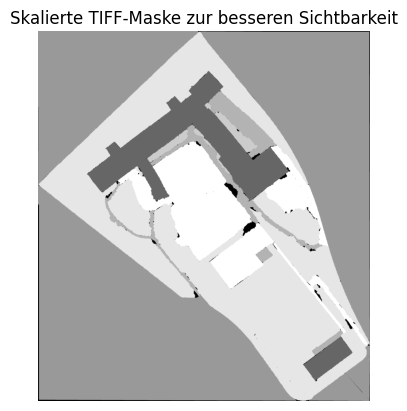

In [ ]:
# Bild laden und Pixelwerte auf Werte von 0 bis 255 skalieren
scaled_img_array = (img_array * 25).clip(0, 255).astype(np.uint8)

# Skalierte Maske anzeigen
plt.imshow(scaled_img_array, cmap='gray')
plt.title("Skalierte TIFF-Maske zur besseren Sichtbarkeit")
plt.axis("off")
plt.show()


### Patches erstellen

In [ ]:
# Pfade für die Ordner der Patches
base_dir = "/content/drive/MyDrive/Data"
patch_dirs = [
    "patches_train_images", "patches_train_masks",
    "patches_val_images", "patches_val_masks", "patches_test_images", "patches_test_masks"
]

# Erstellen der Ordner für die Patches
for patch_dir in patch_dirs:
    full_path = os.path.join(base_dir, patch_dir)
    os.makedirs(full_path, exist_ok=True)
    print(f"Ordner erstellt oder existierte bereits: {full_path}")


Ordner erstellt oder existierte bereits: /content/drive/MyDrive/Data/patches_train_images
Ordner erstellt oder existierte bereits: /content/drive/MyDrive/Data/patches_train_masks
Ordner erstellt oder existierte bereits: /content/drive/MyDrive/Data/patches_val_images
Ordner erstellt oder existierte bereits: /content/drive/MyDrive/Data/patches_val_masks
Ordner erstellt oder existierte bereits: /content/drive/MyDrive/Data/patches_test_images
Ordner erstellt oder existierte bereits: /content/drive/MyDrive/Data/patches_test_masks


In [ ]:
# Verzeichnisse für die Originalbilder
train_images_dir = "/content/drive/MyDrive/Data/train_images"
train_masks_dir = "/content/drive/MyDrive/Data/train_masks"
val_images_dir = "/content/drive/MyDrive/Data/val_images"
val_masks_dir = "/content/drive/MyDrive/Data/val_masks"
test_images_dir = "/content/drive/MyDrive/Data/test_images"
test_masks_dir = "/content/drive/MyDrive/Data/test_masks"  # Verzeichnis für Test-Masken

# Verzeichnisse für die Patches
patches_train_images_dir = "/content/drive/MyDrive/Data/patches_train_images"
patches_train_masks_dir = "/content/drive/MyDrive/Data/patches_train_masks"
patches_val_images_dir = "/content/drive/MyDrive/Data/patches_val_images"
patches_val_masks_dir = "/content/drive/MyDrive/Data/patches_val_masks"
patches_test_images_dir = "/content/drive/MyDrive/Data/patches_test_images"
patches_test_masks_dir = "/content/drive/MyDrive/Data/patches_test_masks"  # Verzeichnis für Test-Masken-Patches

# Zielgröße für die Patches
patch_size = (256, 256)

# Funktion zur Erstellung der Patches
def create_and_save_patches_rasterio(images_dir, masks_dir, patch_size, img_save_dir, mask_save_dir):
    os.makedirs(img_save_dir, exist_ok=True)
    os.makedirs(mask_save_dir, exist_ok=True)

    for image_file in sorted(os.listdir(images_dir)):
        img_path = os.path.join(images_dir, image_file)
        mask_file = f"Copy of {image_file}"  # Masken haben den Zusatz "Copy of "

        with rasterio.open(img_path) as img:
            width, height = img.width, img.height
            num_channels = img.count

            patch_count = 0
            for i in range(0, width, patch_size[0]):
                for j in range(0, height, patch_size[1]):
                    right = min(i + patch_size[0], width)
                    bottom = min(j + patch_size[1], height)
                    window = Window(i, j, right - i, bottom - j)

                    img_patch = img.read(window=window)
                    if img_patch.shape[1] < patch_size[0] or img_patch.shape[2] < patch_size[1]:
                        padded_img = np.zeros((num_channels, patch_size[0], patch_size[1]), dtype=img_patch.dtype)
                        padded_img[:, :img_patch.shape[1], :img_patch.shape[2]] = img_patch
                        img_patch = padded_img

                    img_patch_name = f"{os.path.splitext(image_file)[0]}_patch_{patch_count}.tif"
                    img_patch_path = os.path.join(img_save_dir, img_patch_name)
                    with rasterio.open(
                        img_patch_path, "w",
                        driver="GTiff",
                        height=patch_size[0],
                        width=patch_size[1],
                        count=num_channels,
                        dtype=img.dtypes[0],
                        crs=img.crs,
                        transform=img.window_transform(window),
                    ) as dest:
                        dest.write(img_patch)

                    mask_path = os.path.join(masks_dir, mask_file)
                    with rasterio.open(mask_path) as mask:
                        mask_patch = mask.read(window=window)
                        if mask_patch.shape[1] < patch_size[0] or mask_patch.shape[2] < patch_size[1]:
                            padded_mask = np.zeros((mask.count, patch_size[0], patch_size[1]), dtype=mask_patch.dtype)
                            padded_mask[:, :mask_patch.shape[1], :mask_patch.shape[2]] = mask_patch
                            mask_patch = padded_mask

                        mask_patch_name = f"{os.path.splitext(mask_file)[0]}_patch_{patch_count}.tif"
                        mask_patch_path = os.path.join(mask_save_dir, mask_patch_name)
                        with rasterio.open(
                            mask_patch_path, "w",
                            driver="GTiff",
                            height=patch_size[0],
                            width=patch_size[1],
                            count=mask.count,
                            dtype=mask.dtypes[0],
                            crs=mask.crs,
                            transform=mask.window_transform(window),
                        ) as dest:
                            dest.write(mask_patch)

                    patch_count += 1

            if patch_count == 0:
                print(f"Warnung: Keine Patches für das Bild {image_file} im Ordner {images_dir} erstellt.")

    print(f"Patches erfolgreich erstellt und gespeichert in {img_save_dir} und {mask_save_dir}.")

# Aufruf der Funktion für Trainings-, Validierungs- und Testdaten
create_and_save_patches_rasterio(train_images_dir, train_masks_dir, patch_size, patches_train_images_dir, patches_train_masks_dir)
create_and_save_patches_rasterio(val_images_dir, val_masks_dir, patch_size, patches_val_images_dir, patches_val_masks_dir)
create_and_save_patches_rasterio(test_images_dir, test_masks_dir, patch_size, patches_test_images_dir, patches_test_masks_dir)

print("Alle Patches wurden erfolgreich erstellt.")


Patches erfolgreich erstellt und gespeichert in /content/drive/MyDrive/Data/patches_train_images und /content/drive/MyDrive/Data/patches_train_masks.


### CSV für Pfade zu Train und Val Data zu schaffen

das hier ist der Code um mit den skalierten Bilddaten zu arbeiten. Er speichert die Pfade der skalierten Bilder als CSV ab und das CSV wird ins YAML File eingelesen

In [ ]:
# import os
# import pandas as pd

# # Funktionen zum Abrufen von Bild- und Maskenpfaden aus Verzeichnissen
# def get_file_paths(directory, file_extension=".tif"):
#     return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(file_extension)]

# # Verzeichnisse für Trainings- und Validierungsdaten
# train_images_dir = "/content/drive/MyDrive/Data/scaled_train_images"
# train_masks_dir = "/content/drive/MyDrive/Data/scaled_train_masks"
# val_images_dir = "/content/drive/MyDrive/Data/scaled_val_images"
# val_masks_dir = "/content/drive/MyDrive/Data/scaled_val_masks"
# test_images_dir = "/content/drive/MyDrive/Data/scaled_test_images"

# # Hole alle Pfade zu den Bild- und Masken-Dateien
# train_images = get_file_paths(train_images_dir)
# train_masks = get_file_paths(train_masks_dir)
# val_images = get_file_paths(val_images_dir)
# val_masks = get_file_paths(val_masks_dir)
# test_images = get_file_paths(test_images_dir)

# # Sicherstellen, dass die Anzahl der Bilder und Masken übereinstimmt
# train_images.sort()
# train_masks.sort()
# val_images.sort()
# val_masks.sort()
# test_images.sort()

# # Überprüfen, ob die Anzahl der Trainingsbilder und -masken übereinstimmt
# assert len(train_images) == len(train_masks), "Anzahl der Trainingsbilder und -masken stimmt nicht überein."
# assert len(val_images) == len(val_masks), "Anzahl der Validierungsbilder und -masken stimmt nicht überein."

# # Erstelle DataFrames für Train, Validation und Test
# train_df = pd.DataFrame({"image_path": train_images, "mask_path": train_masks})
# val_df = pd.DataFrame({"image_path": val_images, "mask_path": val_masks})
# test_df = pd.DataFrame({"image_path": test_images, "mask_path": [""] * len(test_images)})

# # Speicherpfade für die CSV-Dateien anpassen
# train_csv_path = "/content/drive/MyDrive/Data/train_paths.csv"
# val_csv_path = "/content/drive/MyDrive/Data/val_paths.csv"
# test_csv_path = "/content/drive/MyDrive/Data/test_paths.csv"

# # Speichere die DataFrames als CSV-Dateien ohne Header und mit Komma als Trennzeichen
# train_df.to_csv(train_csv_path, index=False, header=False, sep=',')
# val_df.to_csv(val_csv_path, index=False, header=False, sep=',')
# test_df.to_csv(test_csv_path, index=False, header=False, sep=',')

# print(f"Train CSV gespeichert unter: {train_csv_path}")
# print(f"Validation CSV gespeichert unter: {val_csv_path}")
# print(f"Test CSV gespeichert unter: {test_csv_path}")


Train CSV gespeichert unter: /content/drive/MyDrive/Data/train_paths.csv
Validation CSV gespeichert unter: /content/drive/MyDrive/Data/val_paths.csv
Test CSV gespeichert unter: /content/drive/MyDrive/Data/test_paths.csv


hier werden nun die Patch-Files als Datengrundlage für das Modell verwendet

In [ ]:
import os
import pandas as pd

# Funktionen zum Abrufen von Bild- und Maskenpfaden aus Verzeichnissen
def get_file_paths(directory, file_extension=".tif"):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(file_extension)]

# Verzeichnisse für die Patches, passend zu deinem bisherigen Code
patches_train_images_dir = "/content/drive/MyDrive/Data/patches_train_images"
patches_train_masks_dir = "/content/drive/MyDrive/Data/patches_train_masks"
patches_val_images_dir = "/content/drive/MyDrive/Data/patches_val_images"
patches_val_masks_dir = "/content/drive/MyDrive/Data/patches_val_masks"
patches_test_images_dir = "/content/drive/MyDrive/Data/patches_test_images"

# Hole alle Pfade zu den Bild- und Masken-Dateien der Patches
train_images = get_file_paths(patches_train_images_dir)
train_masks = get_file_paths(patches_train_masks_dir)
val_images = get_file_paths(patches_val_images_dir)
val_masks = get_file_paths(patches_val_masks_dir)
test_images = get_file_paths(patches_test_images_dir)

# Sicherstellen, dass die Anzahl der Bilder und Masken übereinstimmt
train_images.sort()
train_masks.sort()
val_images.sort()
val_masks.sort()
test_images.sort()

# Überprüfen, ob die Anzahl der Trainings- und Validierungsbilder mit den Masken übereinstimmt
assert len(train_images) == len(train_masks), "Anzahl der Trainingsbilder und -masken stimmt nicht überein."
assert len(val_images) == len(val_masks), "Anzahl der Validierungsbilder und -masken stimmt nicht überein."

# Erstelle DataFrames für Train, Validation und Test
train_df = pd.DataFrame({"image_path": train_images, "mask_path": train_masks})
val_df = pd.DataFrame({"image_path": val_images, "mask_path": val_masks})
# Test-DataFrame ohne Masken, da die Testmasken nicht benötigt werden
test_df = pd.DataFrame({"image_path": test_images, "mask_path": [""] * len(test_images)})

# Speicherpfade für die CSV-Dateien
train_csv_path = "/content/drive/MyDrive/Data/train_paths.csv"
val_csv_path = "/content/drive/MyDrive/Data/val_paths.csv"
test_csv_path = "/content/drive/MyDrive/Data/test_paths.csv"

# Speichere die DataFrames als CSV-Dateien ohne Header und mit Komma als Trennzeichen
train_df.to_csv(train_csv_path, index=False, header=False, sep=',')
val_df.to_csv(val_csv_path, index=False, header=False, sep=',')
test_df.to_csv(test_csv_path, index=False, header=False, sep=',')

print(f"Train CSV gespeichert unter: {train_csv_path}")
print(f"Validation CSV gespeichert unter: {val_csv_path}")
print(f"Test CSV gespeichert unter: {test_csv_path}")


Train CSV gespeichert unter: /content/drive/MyDrive/Data/train_paths.csv
Validation CSV gespeichert unter: /content/drive/MyDrive/Data/val_paths.csv
Test CSV gespeichert unter: /content/drive/MyDrive/Data/test_paths.csv


## YAML file konfigurieren (YAML Flair 1)

In [ ]:
import yaml

# Inhalt des YAML-Files als Python-Dictionary
yaml_content = """
#### DATA PATHS
paths:
    out_folder : "/content/drive/MyDrive/FLAIR"  # Ausgabeverzeichnis für Ergebnisse
    out_model_name: "flair_model"  # Name des Ausgabemodells

    # CSV-Dateien mit Bild-Masken-Paaren für Training und Validierung
    train_csv : "/content/drive/MyDrive/Data/train_paths.csv"
    val_csv   : "/content/drive/MyDrive/Data/val_paths.csv"

    # Optional: Testdaten, falls gewünscht
    test_csv : "/content/drive/MyDrive/Data/test_paths.csv"

    ckpt_model_path: ""  # Falls nötig, Pfad zur Checkpoint-Datei
    path_metadata_aerial: "../flair_aerial_metadata.json"  # Optional: Metadaten-JSON für FLAIR

#### USAGE
tasks:
    train: True  # Modelltraining aktivieren
    train_tasks:
        init_weights_only_from_ckpt: False  # Initialisiere nur Gewichte aus Checkpoint, falls gewünscht
        resume_training_from_ckpt: False  # Fortsetzen eines abgebrochenen Trainings

    predict: True  # Vorhersagen mit dem Modell
    metrics: True  # Berechne Metriken
    delete_preds: True  # Lösche Vorhersagen nach Metrikberechnung

#### TRAINING CONFIGURATION
model_framework:
    model_provider: SegmentationModelsPytorch  # Framework-Provider für das Modell
    SegmentationModelsPytorch:
        encoder_decoder: "resnet34_unet"  # Encoder-Decoder-Konfiguration (resnet34 + U-Net)

use_augmentation: True  # Datenaugmentation aktivieren
transformations:
    - Resize:
        height: 256
        width: 256
    - RandomHorizontalFlip: True
use_metadata: False  # Falls Metadaten verwendet werden, auf True setzen (z.B. bei FLAIR)

channels: [1, 2, 3, 4]  # Eingabekanäle, z.B. RGB + NIR
norm_type: custom  # Normalisierungstyp (custom für Mean-Std)
norm_means: [105.08, 110.87, 101.82, 106.38]  # Mittelwerte für custom-Normalisierung
norm_stds: [52.17, 45.38, 44, 39.69]  # Standardabweichungen für custom-Normalisierung

seed: 2022  # Zufallswert für Reproduzierbarkeit
batch_size: 2  # Batchgröße
learning_rate: 0.02  # Lernrate
num_epochs: 50  # Anzahl der Trainingsepochen

#### DATA CONFIGURATION
use_weights: True  # Verwende Gewichtung der Klassen während des Trainings
classes: # Klassen-ID und Namen für semantische Segmentierung
    1:  [1, 'Begrünte Belagsfläche']
    2:  [1, 'Blaue Fläche']
    3:  [1, 'Durchlässige Belagsfläche']
    4:  [1, 'Gebäude']
    5:  [1, 'Gebäudebegrünungen']
    6:  [1, 'Keine Zuordnung']
    7:  [1, 'Teilversiegelte Belagsfläche']
    8:  [1, 'Vegetationsfläche']
    9:  [1, 'Vegetationsfläche mit Bodenanschluss']
    10: [1, 'Versiegelte Belagsflächen']
    0: [0, 'background']  # Hintergrundklasse

#### PREDICTION CONFIGURATION
georeferencing_output : True  # Georeferenzierte Ausgabe aktivieren

#### COMPUTATIONAL RESOURCES
accelerator: gpu  # 'gpu' für GPU-Training, 'cpu' für CPU
num_nodes: 1  # Anzahl der verwendeten Knoten
gpus_per_node: 1  # Anzahl der GPUs pro Knoten
strategy: 'auto'  # Strategie für verteiltes Training, falls nötig
num_workers: 10  # Anzahl der Arbeiter für Daten-Loading

#### CHECKPOINT OPTIONS
ckpt_save_also_last: True  # Speichere auch das letzte Epoch-Checkpoint
ckpt_verbose: False  # Ausführliche Informationen beim Speichern des Checkpoints
ckpt_weights_only: False  # Speichere nur die Gewichte, um Speicherplatz zu sparen
ckpt_monitor: val_loss  # Metrik für Checkpoint-Speicherung
ckpt_monitor_mode: min  # Speicher niedrigsten Wert für val_loss
ckpt_earlystopping_patience: 30  # Abbruch bei keiner Verbesserung nach 30 Epochen

#### PROGRESS PRINTING
cp_csv_and_conf_to_output: True  # Kopiere Pfade-CSV und Konfiguration zum Ausgabeverzeichnis
enable_progress_bar: True  # Zeige Fortschrittsbalken während des Trainings
progress_rate: 10  # Fortschrittsrate für die Anzeige
"""

# Speichere das YAML-File
with open("/content/drive/MyDrive/FLAIR/flair-1-config.yaml", "w") as file:
    file.write(yaml_content)

In [ ]:
!flair --conf=/content/drive/MyDrive/FLAIR/flair-1-config.yaml

Starting : 2024-11-06  22:09

Configuration Tree:
|- paths:
|   |- out_folder: /content/drive/MyDrive/FLAIR
|   |- out_model_name: flair_model
|   |- train_csv: /content/drive/MyDrive/Data/train_paths.csv
|   |- val_csv: /content/drive/MyDrive/Data/val_paths.csv
|   |- test_csv: /content/drive/MyDrive/Data/test_paths.csv
|   |- ckpt_model_path: 
|   |- path_metadata_aerial: ../flair_aerial_metadata.json
|- tasks:
|   |- train: True
|   |- train_tasks:
|   |   |- init_weights_only_from_ckpt: False
|   |   |- resume_training_from_ckpt: False
|   |- predict: True
|   |- metrics: True
|   |- delete_preds: True
|- model_framework:
|   |- model_provider: SegmentationModelsPytorch
|   |- SegmentationModelsPytorch:
|   |   |- encoder_decoder: resnet34_unet
|- use_augmentation: True
|- transformations: [{'Resize': {'height': 256, 'width': 256}}, {'RandomHorizontalFlip': True}]
|- use_metadata: False
|- channels: [1, 2, 3, 4]
|- norm_type: custom
|- norm_means: [105.08, 110.87, 101.82, 106.38]
|

Die neue Fehlermeldung Error at index 0: 'float' object has no attribute 'read' deutet darauf hin, dass das Skript versucht, eine Objektoperation auf einer Datei oder einem Datensatz durchzuführen, aber stattdessen eine Zahl (float) erhält. Dies kann passieren, wenn an einer Stelle im Code erwartet wird, dass eine Datei oder ein Array gelesen wird, aber stattdessen eine falsche Datenstruktur oder ein unerwarteter Wert übergeben wird.

Zusätzlich wird eine AxisError bei numpy angezeigt, was darauf hindeutet, dass eine leere Konfusionsmatrix verarbeitet wird – also keine Klassendaten für bestimmte Klassen vorliegen oder eine der Klassen in den Daten gar nicht vorhanden ist.

--> Datenaugmentation hinzufügen
Um die Variabilität seltener Klassen zu erhöhen, füge gezielte Augmentationen in deinem YAML-File unter transformations hinzu. Hier sind einige Augmentationsmethoden, die helfen können:
Horizontal/Vertical Flip: RandomHorizontalFlip, RandomVerticalFlip für zufällige Spiegelungen.
Rotation: RandomRotation, um die Perspektive zu variieren.
Color Jitter: ColorJitter, um die Farbtöne anzupassen (nützlich für Klassen wie „blaue Fläche“).

## YAML file konfigurieren (Versuch 2: YAML Flair 1)

das folgende YAML file enthält nun mehr Transformations zur Data Augementation

In [ ]:
import yaml

# Inhalt des YAML-Files als Python-Dictionary
yaml_content = """
#### DATA PATHS
paths:
    out_folder : "/content/drive/MyDrive/FLAIR"  # Ausgabeverzeichnis für Ergebnisse
    out_model_name: "flair_model"  # Name des Ausgabemodells

    # CSV-Dateien mit Bild-Masken-Paaren für Training und Validierung
    train_csv : "/content/drive/MyDrive/Data/train_paths.csv"
    val_csv   : "/content/drive/MyDrive/Data/val_paths.csv"

    # Optional: Testdaten, falls gewünscht
    test_csv : "/content/drive/MyDrive/Data/test_paths.csv"

    ckpt_model_path: ""  # Falls nötig, Pfad zur Checkpoint-Datei
    path_metadata_aerial: "../flair_aerial_metadata.json"  # Optional: Metadaten-JSON für FLAIR

#### USAGE
tasks:
    train: True  # Modelltraining aktivieren
    train_tasks:
        init_weights_only_from_ckpt: False  # Initialisiere nur Gewichte aus Checkpoint, falls gewünscht
        resume_training_from_ckpt: False  # Fortsetzen eines abgebrochenen Trainings

    predict: True  # Vorhersagen mit dem Modell
    metrics: True  # Berechne Metriken
    delete_preds: True  # Lösche Vorhersagen nach Metrikberechnung

#### TRAINING CONFIGURATION
model_framework:
    model_provider: SegmentationModelsPytorch  # Framework-Provider für das Modell
    SegmentationModelsPytorch:
        encoder_decoder: "resnet34_unet"  # Encoder-Decoder-Konfiguration (resnet34 + U-Net)

use_augmentation: True  # Datenaugmentation aktivieren
transformations:
  - Resize: {height: 256, width: 256}
  - RandomHorizontalFlip: True
  - RandomVerticalFlip: True
  - RandomRotation: {degrees: 15}
  - ColorJitter: {brightness: 0.2, contrast: 0.2, saturation: 0.2, hue: 0.1}
use_metadata: False  # Falls Metadaten verwendet werden, auf True setzen (z.B. bei FLAIR)

channels: [1, 2, 3, 4]  # Eingabekanäle, z.B. RGB + NIR
norm_type: custom  # Normalisierungstyp (custom für Mean-Std)
norm_means: [105.08, 110.87, 101.82, 106.38]  # Mittelwerte für custom-Normalisierung
norm_stds: [52.17, 45.38, 44, 39.69]  # Standardabweichungen für custom-Normalisierung

seed: 2022  # Zufallswert für Reproduzierbarkeit
batch_size: 2  # Batchgröße
learning_rate: 0.02  # Lernrate
num_epochs: 50  # Anzahla der Trainingsepochen

#### DATA CONFIGURATION
use_weights: True  # Verwende Gewichtung der Klassen während des Trainings
classes: # Klassen-ID und Namen für semantische Segmentierung
    1:  [1, 'Begrünte Belagsfläche']
    2:  [1, 'Blaue Fläche']
    3:  [1, 'Durchlässige Belagsfläche']
    4:  [1, 'Gebäude']
    5:  [1, 'Gebäudebegrünungen']
    6:  [1, 'Keine Zuordnung']
    7:  [1, 'Teilversiegelte Belagsfläche']
    8:  [1, 'Vegetationsfläche']
    9:  [1, 'Vegetationsfläche mit Bodenanschluss']
    10: [1, 'Versiegelte Belagsflächen']
    0: [0, 'background']  # Hintergrundklasse

#### PREDICTION CONFIGURATION
georeferencing_output : True  # Georeferenzierte Ausgabe aktivieren

#### COMPUTATIONAL RESOURCES
accelerator: gpu  # 'gpu' für GPU-Training, 'cpu' für CPU
num_nodes: 1  # Anzahl der verwendeten Knoten
gpus_per_node: 1  # Anzahl der GPUs pro Knoten
strategy: 'auto'  # Strategie für verteiltes Training, falls nötig
num_workers: 10  # Anzahl der Arbeiter für Daten-Loading

#### CHECKPOINT OPTIONS
ckpt_save_also_last: True  # Speichere auch das letzte Epoch-Checkpoint
ckpt_verbose: False  # Ausführliche Informationen beim Speichern des Checkpoints
ckpt_weights_only: False  # Speichere nur die Gewichte, um Speicherplatz zu sparen
ckpt_monitor: val_loss  # Metrik für Checkpoint-Speicherung
ckpt_monitor_mode: min  # Speicher niedrigsten Wert für val_loss
ckpt_earlystopping_patience: 30  # Abbruch bei keiner Verbesserung nach 30 Epochen

#### PROGRESS PRINTING
cp_csv_and_conf_to_output: True  # Kopiere Pfade-CSV und Konfiguration zum Ausgabeverzeichnis
enable_progress_bar: True  # Zeige Fortschrittsbalken während des Trainings
progress_rate: 10  # Fortschrittsrate für die Anzeige
"""

# Speichere das YAML-File
with open("/content/drive/MyDrive/FLAIR/flair-1-config.yaml", "w") as file:
    file.write(yaml_content)

In [ ]:
!flair --conf=/content/drive/MyDrive/FLAIR/flair-1-config.yaml

Starting : 2024-11-09  11:28

Configuration Tree:
|- paths:
|   |- out_folder: /content/drive/MyDrive/FLAIR
|   |- out_model_name: flair_model
|   |- train_csv: /content/drive/MyDrive/Data/train_paths.csv
|   |- val_csv: /content/drive/MyDrive/Data/val_paths.csv
|   |- test_csv: /content/drive/MyDrive/Data/test_paths.csv
|   |- ckpt_model_path: 
|   |- path_metadata_aerial: ../flair_aerial_metadata.json
|- tasks:
|   |- train: True
|   |- train_tasks:
|   |   |- init_weights_only_from_ckpt: False
|   |   |- resume_training_from_ckpt: False
|   |- predict: True
|   |- metrics: True
|   |- delete_preds: True
|- model_framework:
|   |- model_provider: SegmentationModelsPytorch
|   |- SegmentationModelsPytorch:
|   |   |- encoder_decoder: resnet34_unet
|- use_augmentation: True
|- transformations: [{'Resize': {'height': 256, 'width': 256}}, {'RandomHorizontalFlip': True}, {'RandomVerticalFlip': True}, {'RandomRotation': {'degrees': 15}}, {'ColorJitter': {'brightness': 0.2, 'contrast': 0.2,

Globale Metriken
mIoU (Mean Intersection over Union):

Die durchschnittliche IoU beträgt 17.26%. Das bedeutet, dass das Modell Schwierigkeiten hat, die Klassen präzise vorherzusagen. Eine höhere mIoU wäre wünschenswert, um zu zeigen, dass die vorhergesagten und tatsächlichen Pixel in den verschiedenen Klassen besser übereinstimmen.
Overall Accuracy (Gesamtgenauigkeit):

57.49% der Pixel werden korrekt vorhergesagt. Dies ist eine einfache Genauigkeit, die den Anteil korrekt klassifizierter Pixel (über alle Klassen hinweg) angibt. Eine moderate Gesamtgenauigkeit, jedoch keine sehr hohe IoU für die meisten Klassen.
Fscore:

Der Fscore liegt bei 20.81 und kombiniert die Präzision und den Recall in einer Metrik. Ein höherer Wert würde eine bessere Balance zwischen diesen beiden Metriken anzeigen.
Precision und Recall:

Precision (22.64): Anteil der korrekt vorhergesagten positiven Pixel. Das bedeutet, dass nur etwa 22.64% der vorhergesagten Pixel tatsächlich korrekt sind.
Recall (28.24): Anteil der tatsächlichen positiven Pixel, die korrekt vorhergesagt wurden. Das bedeutet, dass etwa 28.24% der tatsächlichen Pixel für jede Klasse korrekt vorhergesagt wurden.
Klassenbasierte Metriken
Die Zeilen mit den Klassennamen enthalten die Bewertung für jede Klasse:

Begrünte Belagsfläche, Blaue Fläche, Durchlässige Belagsfläche und andere spezifische Flächenarten haben 0% IoU und F-score:

Dies zeigt, dass das Modell Schwierigkeiten hat, diese Klassen korrekt zu identifizieren, was auf eine unzureichende Unterscheidung dieser Klassen in den Daten hindeuten könnte. Möglicherweise liegt das an einem ungleichen Klassenverhältnis oder an Daten, die nicht spezifisch genug für diese Klassen sind.
Gebäude:

Diese Klasse hat eine IoU von 6.87% und einen F-score von 12.86. Auch hier ist der Wert niedrig, was bedeutet, dass das Modell Gebäude erkennt, aber nicht sehr präzise. Präzision und Recall sind in dieser Klasse ungleichmäßig verteilt (hohe Präzision, niedriger Recall), was darauf hindeutet, dass die Klasse erkannt wird, aber häufig auch andere Klassen vorhergesagt werden.
Keine Zuordnung:

Die Klasse Keine Zuordnung hat eine sehr hohe IoU von 95.26% und einen F-score von 97.57. Dies zeigt, dass das Modell diese Klasse sehr gut erkennt und sie präzise und mit hoher Übereinstimmung vorhersagt. Es könnte sein, dass diese Klasse aufgrund ihrer Häufigkeit im Datensatz dominiert und daher besonders gut gelernt wird.
Vegetationsfläche mit Bodenanschluss:

Diese Klasse zeigt eine IoU von 55.11% und einen F-score von 71.06. Es scheint, dass das Modell diesen Klassentyp relativ gut identifizieren kann.
Versiegelte Belagsflächen:

Diese Klasse hat eine IoU von 15.37% und einen F-score von 26.65. Es gibt hier noch Verbesserungspotential, da das Modell einige dieser Bereiche erkennt, aber nicht zuverlässig genug ist.
Problematische Klassen
Die Meldung "Not learned Classes" deutet darauf hin, dass einige Klassen im Training ignoriert wurden oder das Modell für diese Klassen keine sinnvolle Vorhersage machen konnte. Die Klasse background wurde nicht erfolgreich gelernt.

Mögliche Gründe für die niedrigen Werte und Verbesserungsmöglichkeiten
Ungleichgewicht in den Klassen: Klassen wie "Keine Zuordnung" könnten viel häufiger vertreten sein, was dazu führt, dass das Modell sie bevorzugt.
Datenrepräsentation: Einige Klassen haben möglicherweise nicht genug Variabilität in den Trainingsdaten, was das Modell einschränkt.
Trainingszeit und Architektur: Vielleicht könnte ein längeres Training oder eine komplexere Architektur (z. B. ein Modell mit mehr Kapazität) helfen, diese Klassen besser zu erkennen.
Zusätzliche Augmentation: Das Hinzufügen weiterer Bild-Transformationen könnte helfen, das Modell zu verbessern, indem es mehr Beispiele für jede Klasse sieht.
Die Ergebnisse legen nahe, dass für die spezifischen Klassen mehr Daten und möglicherweise eine Anpassung der Trainingsparameter erforderlich sind, um eine bessere Performance zu erreichen.

## Analyse

<ipython-input-14-d1401ae4cac8>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))["state_dict"]


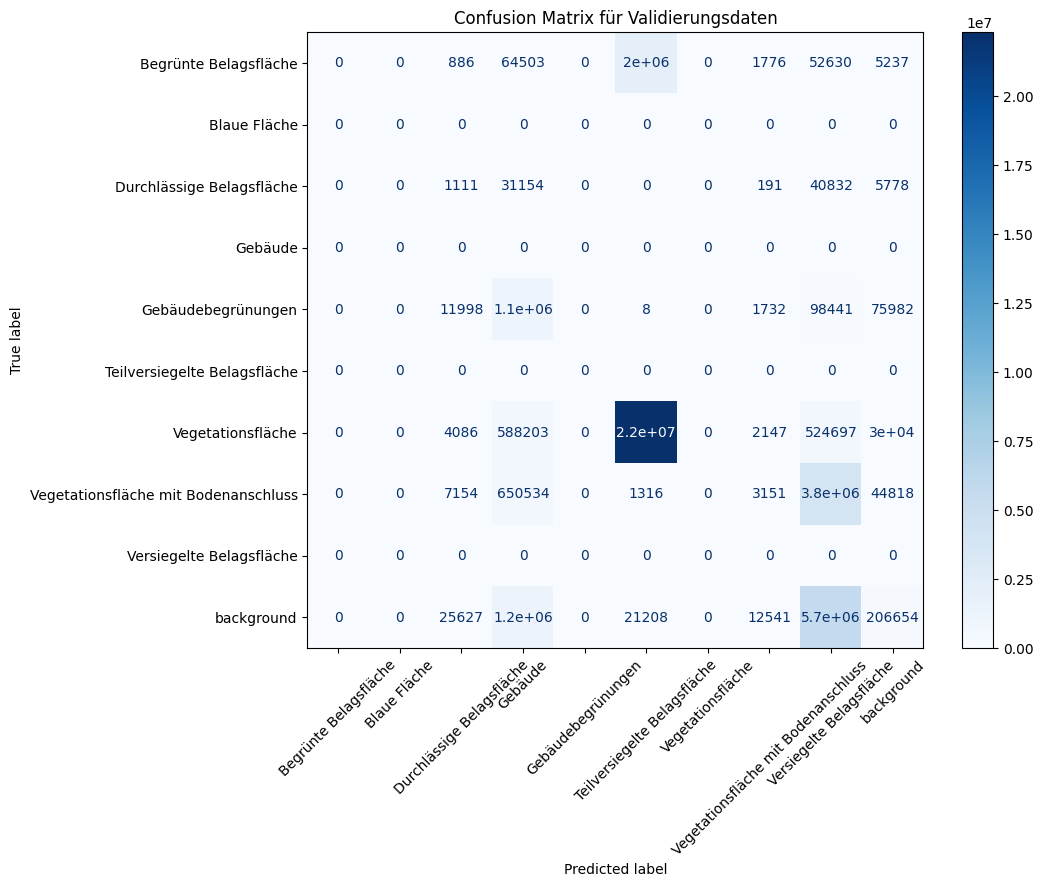

In [ ]:
import numpy as np
import pandas as pd
import torch
import rasterio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from segmentation_models_pytorch import Unet

# 1. Modell laden
model = Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=4,
    classes=11
)

# Checkpoint laden
checkpoint_path = "/content/drive/MyDrive/FLAIR/flair_model/checkpoints/last.ckpt"
state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))["state_dict"]
filtered_state_dict = {
    k.replace("model.seg_model.", ""): v
    for k, v in state_dict.items()
    if k.replace("model.seg_model.", "") in model.state_dict()
}
model.load_state_dict(filtered_state_dict, strict=False)
model.eval()

# 2. Ground-Truth- und Vorhersagedaten laden
val_csv_path = "/content/drive/MyDrive/Data/val_paths.csv"
val_data = pd.read_csv(val_csv_path, header=None, names=["image", "mask"])

ground_truth = []
predictions = []

for _, row in val_data.iterrows():
    # Ground Truth laden
    with rasterio.open(row["mask"]) as src:
        gt_mask = src.read(1)  # Nur die erste Bandmaske
        ground_truth.append(gt_mask.ravel())

    # Eingabebild laden und normalisieren
    with rasterio.open(row["image"]) as src:
        img = src.read()
        mean = np.array([105.08, 110.87, 101.82, 106.38])
        std = np.array([52.17, 45.38, 44, 39.69])
        img = (img - mean[:, None, None]) / std[:, None, None]

    # Vorhersagen
    with torch.no_grad():
        input_tensor = torch.from_numpy(img).float().unsqueeze(0)
        pred = model(input_tensor)
        pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()
        predictions.append(pred_mask.ravel())

# Arrays für Ground Truth und Predictions
ground_truth = np.concatenate(ground_truth)
predictions = np.concatenate(predictions)

# 3. Confusion Matrix berechnen
classes = [
    "Begrünte Belagsfläche", "Blaue Fläche", "Durchlässige Belagsfläche",
    "Gebäude", "Gebäudebegrünungen", "Teilversiegelte Belagsfläche",
    "Vegetationsfläche", "Vegetationsfläche mit Bodenanschluss",
    "Versiegelte Belagsfläche", "background"
]

cm = confusion_matrix(ground_truth, predictions, labels=list(range(len(classes))))

# 4. Confusion Matrix visualisieren
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix für Validierungsdaten")
plt.show()


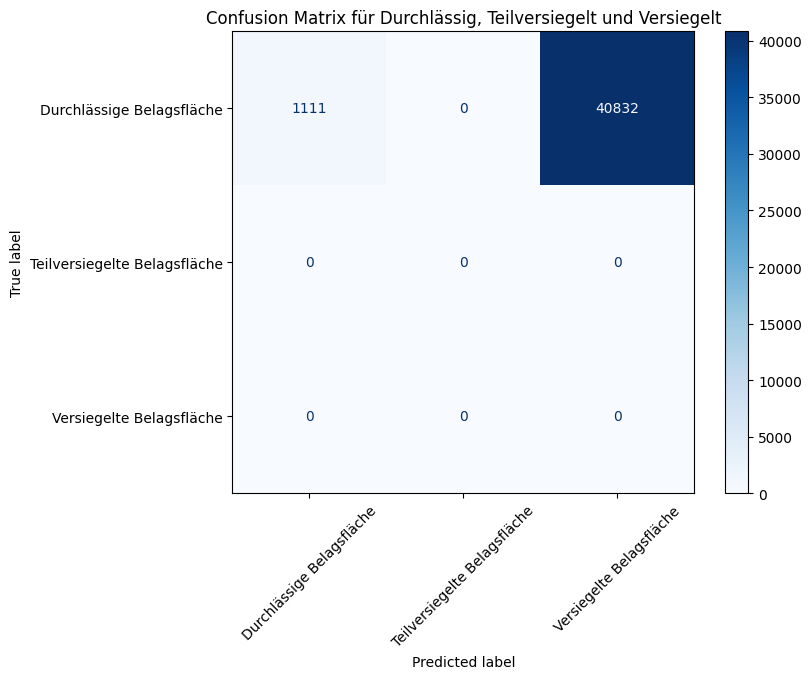

In [ ]:
# Filter für die drei Kategorien: Teilversiegelt, Durchlässig, Versiegelt
selected_classes = ["Durchlässige Belagsfläche", "Teilversiegelte Belagsfläche", "Versiegelte Belagsfläche"]
selected_indices = [classes.index(cls) for cls in selected_classes]

# Confusion Matrix für die ausgewählten Klassen extrahieren
filtered_cm = cm[np.ix_(selected_indices, selected_indices)]

# Visualisierung der gefilterten Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=filtered_cm, display_labels=selected_classes)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix für Durchlässig, Teilversiegelt und Versiegelt")
plt.show()

# FLAIR Model 2 mit Data Augmentation

## Data Preperation

In [ ]:
import os
import numpy as np
import rasterio
import albumentations as A

# Verzeichnisse für die Original- und augmentierten Trainingsbilder und -masken
train_images_dir = "/content/drive/MyDrive/Data/train_images"
train_masks_dir = "/content/drive/MyDrive/Data/train_masks"
augmented_images_dir = "/content/drive/MyDrive/Data/augmented_train_images"
augmented_masks_dir = "/content/drive/MyDrive/Data/augmented_train_masks"

# Anzahl der Augmentierungen pro Bild
num_augmentations = 5

# Augmentierungspipeline erstellen (ohne Größenänderung)
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
])

# Sicherstellen, dass die Ausgabeordner existieren
os.makedirs(augmented_images_dir, exist_ok=True)
os.makedirs(augmented_masks_dir, exist_ok=True)

# Augmentierung anwenden
for image_file, mask_file in zip(sorted(os.listdir(train_images_dir)), sorted(os.listdir(train_masks_dir))):
    img_path = os.path.join(train_images_dir, image_file)
    mask_path = os.path.join(train_masks_dir, mask_file)

    # TIFF-Bild und Maske als numpy-Arrays laden
    with rasterio.open(img_path) as img:
        image = img.read()  # Alle Bänder laden
        transform = img.transform
        crs = img.crs
        profile = img.profile  # Profil des Bildes speichern

    with rasterio.open(mask_path) as mask:
        mask_data = mask.read(1)  # Nur das erste Band der Maske laden
        mask_profile = mask.profile  # Profil der Maske speichern

    # RGB und Infrarotkanal trennen
    rgb_image = image[:3].transpose(1, 2, 0)  # RGB für Augmentierung
    infrared_channel = image[3]               # Infrarot separat

    for i in range(num_augmentations):
        # Augmentierung anwenden auf RGB und Maske
        augmented = augmentation(image=rgb_image, mask=mask_data)
        augmented_rgb = augmented['image']
        augmented_mask = augmented['mask']

        # Infrarotkanal auf die Größe des augmentierten RGB-Bildes zuschneiden oder skalieren
        infrared_resized = np.resize(infrared_channel, (augmented_rgb.shape[0], augmented_rgb.shape[1]))
        augmented_image = np.dstack([augmented_rgb, infrared_resized]).transpose(2, 0, 1)

        # Pfade für die augmentierten Bilder und Masken
        augmented_image_path = os.path.join(augmented_images_dir, f"aug_{i}_{image_file}")
        augmented_mask_path = os.path.join(augmented_masks_dir, f"aug_{i}_{mask_file}")

        # Speichern des augmentierten Bildes
        profile.update(dtype=augmented_image.dtype, height=augmented_image.shape[1], width=augmented_image.shape[2], count=4)
        with rasterio.open(augmented_image_path, "w", **profile) as dest:
            dest.write(augmented_image)

        # Speichern der augmentierten Maske
        mask_profile.update(dtype=augmented_mask.dtype, height=augmented_mask.shape[0], width=augmented_mask.shape[1])
        with rasterio.open(augmented_mask_path, "w", **mask_profile) as dest:
            dest.write(augmented_mask, 1)

print("Mehrere Augmentierungen erfolgreich durchgeführt und gespeichert.")


Mehrere Augmentierungen erfolgreich durchgeführt und gespeichert.


### Patches für augmented Images erstellen

In [ ]:
import os
import rasterio
from rasterio.windows import Window
import numpy as np

# Verzeichnisse für die augmentierten Bilder und Masken
augmented_images_dir = "/content/drive/MyDrive/Data/augmented_train_images"
augmented_masks_dir = "/content/drive/MyDrive/Data/augmented_train_masks"

# Verzeichnisse für die Patches
patches_augmented_images_dir = "/content/drive/MyDrive/Data/patches_augmented_train_images"
patches_augmented_masks_dir = "/content/drive/MyDrive/Data/patches_augmented_train_masks"

# Zielgröße für die Patches
patch_size = (256, 256)

# Funktion zur Erstellung der Patches für alle Dateien im Verzeichnis
def create_and_save_patches(images_dir, masks_dir, patch_size, img_save_dir, mask_save_dir):
    os.makedirs(img_save_dir, exist_ok=True)
    os.makedirs(mask_save_dir, exist_ok=True)

    # Überprüfung der Verzeichnisse
    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))

    print(f"Anzahl der Bilder: {len(image_files)}, Anzahl der Masken: {len(mask_files)}")

    # Iteriere über alle Bild- und Maskendateien im Verzeichnis
    for image_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(images_dir, image_file)
        mask_path = os.path.join(masks_dir, mask_file)

        # Prüfen, ob Bild und Maske den gleichen Namen (ohne Präfix) haben
        if os.path.splitext(image_file)[0] != os.path.splitext(mask_file)[0].replace("Copy of ", ""):
            print(f"Warnung: Bild und Maske stimmen nicht überein: {image_file} und {mask_file}")
            continue

        # Öffne das Bild und die Maske
        with rasterio.open(img_path) as img, rasterio.open(mask_path) as mask:
            width, height = img.width, img.height
            mask_width, mask_height = mask.width, mask.height

            # Prüfen, ob die Bild- und Maskengröße übereinstimmen
            if width != mask_width or height != mask_height:
                print(f"Warnung: Bild- und Maskengröße stimmen nicht überein für {image_file} und {mask_file}.")
                continue

            num_channels = img.count
            patch_count = 0

            for i in range(0, width, patch_size[0]):
                for j in range(0, height, patch_size[1]):
                    right = min(i + patch_size[0], width)
                    bottom = min(j + patch_size[1], height)
                    window = Window(i, j, right - i, bottom - j)

                    # Lese und speichere den Bild-Patch
                    img_patch = img.read(window=window)
                    if img_patch.shape[1] < patch_size[0] or img_patch.shape[2] < patch_size[1]:
                        padded_img = np.zeros((num_channels, patch_size[0], patch_size[1]), dtype=img_patch.dtype)
                        padded_img[:, :img_patch.shape[1], :img_patch.shape[2]] = img_patch
                        img_patch = padded_img

                    img_patch_name = f"{os.path.splitext(image_file)[0]}_patch_{patch_count}.tif"
                    img_patch_path = os.path.join(img_save_dir, img_patch_name)
                    with rasterio.open(
                        img_patch_path, "w",
                        driver="GTiff",
                        height=patch_size[0],
                        width=patch_size[1],
                        count=num_channels,
                        dtype=img.dtypes[0],
                        crs=img.crs,
                        transform=img.window_transform(window),
                    ) as dest:
                        dest.write(img_patch)

                    # Lese und speichere den Masken-Patch
                    mask_patch = mask.read(window=window)
                    if mask_patch.shape[1] < patch_size[0] or mask_patch.shape[2] < patch_size[1]:
                        padded_mask = np.zeros((mask.count, patch_size[0], patch_size[1]), dtype=mask_patch.dtype)
                        padded_mask[:, :mask_patch.shape[1], :mask_patch.shape[2]] = mask_patch
                        mask_patch = padded_mask

                    mask_patch_name = f"{os.path.splitext(mask_file)[0]}_patch_{patch_count}.tif"
                    mask_patch_path = os.path.join(mask_save_dir, mask_patch_name)
                    with rasterio.open(
                        mask_patch_path, "w",
                        driver="GTiff",
                        height=patch_size[0],
                        width=patch_size[1],
                        count=mask.count,
                        dtype=mask.dtypes[0],
                        crs=mask.crs,
                        transform=mask.window_transform(window),
                    ) as dest:
                        dest.write(mask_patch)

                    patch_count += 1

            if patch_count == 0:
                print(f"Warnung: Keine Patches für das Bild {image_file} im Ordner {images_dir} erstellt.")

    print(f"Patches erfolgreich erstellt und gespeichert in {img_save_dir} und {mask_save_dir}.")

# Aufruf der Funktion für die augmentierten Trainingsbilder und -masken
create_and_save_patches(augmented_images_dir, augmented_masks_dir, patch_size, patches_augmented_images_dir, patches_augmented_masks_dir)

print("Alle Patches für die augmentierten Bilder wurden erfolgreich erstellt.")


Anzahl der Bilder: 30, Anzahl der Masken: 30


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:365: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Patches erfolgreich erstellt und gespeichert in /content/drive/MyDrive/Data/patches_augmented_train_images und /content/drive/MyDrive/Data/patches_augmented_train_masks.
Alle Patches für die augmentierten Bilder wurden erfolgreich erstellt.


### CSV anpassen

In [ ]:
import os
import pandas as pd

# Funktionen zum Abrufen von Bild- und Maskenpfaden aus Verzeichnissen
def get_file_paths(directory, file_extension=".tif"):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(file_extension)]

# Verzeichnisse für die augmentierten Trainingspatches
patches_augmented_train_images_dir = "/content/drive/MyDrive/Data/patches_augmented_train_images"
patches_augmented_train_masks_dir = "/content/drive/MyDrive/Data/patches_augmented_train_masks"

# Hole alle Pfade zu den Bild- und Masken-Dateien der augmentierten Patches
augmented_train_images = get_file_paths(patches_augmented_train_images_dir)
augmented_train_masks = get_file_paths(patches_augmented_train_masks_dir)

# Sortiere die Listen
augmented_train_images.sort()
augmented_train_masks.sort()

# Bereinige 'Copy of' in den Maskennamen für die Zuordnung
def normalize_filename(filename):
    return filename.replace("Copy of ", "")

# Nur Basenames zum Vergleich
image_basenames = {normalize_filename(os.path.basename(f)) for f in augmented_train_images}
mask_basenames = {normalize_filename(os.path.basename(f)) for f in augmented_train_masks}

# Fehlende Masken oder Bilder finden
fehlende_masken = image_basenames - mask_basenames
fehlende_bilder = mask_basenames - image_basenames

# Gebe Dateinamen zur Überprüfung aus
if fehlende_masken or fehlende_bilder:
    print("Alle gefundene Bilder im Verzeichnis:")
    print("\n".join(image_basenames))
    print("\nAlle gefundene Masken im Verzeichnis:")
    print("\n".join(mask_basenames))

    print("\nFehlende Masken für folgende Bilder:")
    for file in fehlende_masken:
        print(file)

    print("\nFehlende Bilder für folgende Masken:")
    for file in fehlende_bilder:
        print(file)
else:
    # Erstelle DataFrame für die augmentierten Trainingsdaten
    augmented_train_df = pd.DataFrame({
        "image_path": augmented_train_images,
        "mask_path": augmented_train_masks
    })

    # Speicherpfad für die CSV-Datei
    augmented_train_csv_path = "/content/drive/MyDrive/Data/augmented_train_paths.csv"

    # Speichere die DataFrame als CSV-Datei ohne Header und mit Komma als Trennzeichen
    augmented_train_df.to_csv(augmented_train_csv_path, index=False, header=False, sep=',')

    print(f"Augmented Train CSV gespeichert unter: {augmented_train_csv_path}")


Augmented Train CSV gespeichert unter: /content/drive/MyDrive/Data/augmented_train_paths.csv


## YAML File konfigurieren (5 epochs)

Anpassungen im Modell:
Weniger Epochen:

Setze die Anzahl der Epochen zunächst auf etwa 5, um zu sehen, ob sich die Loss-Funktion und die Metriken zumindest etwas verbessern. Das gibt dir einen ersten Eindruck davon, ob das Modell lernfähig ist.
Höhere Lernrate:

Probiere, die Lernrate zu erhöhen, von 0.02 auf 0.03, wenn das Modell sehr langsam lernt. Eine höhere Lernrate kann dazu führen, dass das Modell schneller erste Ergebnisse zeigt, aber es kann auch instabil werden und über größere Sprünge in der Loss-Funktion machen.
Alternativ kannst du mit einem Lernraten-Scheduler arbeiten, der die Lernrate über die Zeit reduziert, falls die höheren Werte doch zu stark fluktuieren.
Starkes Early Stopping:

Setze das early_stopping_patience auf etwa 3, sodass das Training früh abbricht, wenn sich die Validierungsmetriken nicht verbessern.



In [ ]:
import yaml

# Inhalt des YAML-Files als Python-Dictionary
yaml_content = """
#### DATA PATHS
paths:
    out_folder : "/content/drive/MyDrive/FLAIR"  # Ausgabeverzeichnis für Ergebnisse
    out_model_name: "flair_model 2"  # Name des Ausgabemodells

    # CSV-Dateien mit Bild-Masken-Paaren für Training und Validierung
    train_csv : "/content/drive/MyDrive/Data/augmented_train_paths.csv"
    val_csv   : "/content/drive/MyDrive/Data/val_paths.csv"

    # Optional: Testdaten, falls gewünscht
    test_csv : "/content/drive/MyDrive/Data/test_paths.csv"

    ckpt_model_path: ""  # Falls nötig, Pfad zur Checkpoint-Datei
    path_metadata_aerial: "../flair_aerial_metadata.json"  # Optional: Metadaten-JSON für FLAIR

#### USAGE
tasks:
    train: True  # Modelltraining aktivieren
    train_tasks:
        init_weights_only_from_ckpt: False  # Initialisiere nur Gewichte aus Checkpoint, falls gewünscht
        resume_training_from_ckpt: False  # Fortsetzen eines abgebrochenen Trainings
        early_stopping:
            monitor: val_loss  # oder eine andere Metrik wie val_miou, falls verfügbar
            patience: 3  # Anzahl der Epochen ohne Verbesserung, bevor abgebrochen wird
            mode: min  # Da 'val_loss' minimiert werden soll; für 'max' wäre dies bei Accuracy/Miou sinnvoll

    predict: True  # Vorhersagen mit dem Modell
    metrics: True  # Berechne Metriken
    delete_preds: True  # Lösche Vorhersagen nach Metrikberechnung

#### TRAINING CONFIGURATION
model_framework:
    model_provider: SegmentationModelsPytorch  # Framework-Provider für das Modell
    SegmentationModelsPytorch:
        encoder_decoder: "resnet34_unet"  # Encoder-Decoder-Konfiguration (resnet34 + U-Net)

use_augmentation: True  # Datenaugmentation aktivieren
transformations:
  - Resize: {height: 256, width: 256}
  - RandomHorizontalFlip: True
  - RandomVerticalFlip: True
  - RandomRotation: {degrees: 15}
  - ColorJitter: {brightness: 0.2, contrast: 0.2, saturation: 0.2, hue: 0.1}
use_metadata: False  # Falls Metadaten verwendet werden, auf True setzen (z.B. bei FLAIR)

channels: [1, 2, 3, 4]  # Eingabekanäle, z.B. RGB + NIR
norm_type: custom  # Normalisierungstyp (custom für Mean-Std)
norm_means: [105.08, 110.87, 101.82, 106.38]  # Mittelwerte für custom-Normalisierung
norm_stds: [52.17, 45.38, 44, 39.69]  # Standardabweichungen für custom-Normalisierung

seed: 2022  # Zufallswert für Reproduzierbarkeit
batch_size: 2  # Batchgröße
learning_rate: 0.03  # Lernrate
num_epochs: 5  # Anzahl der Trainingsepochen

#### DATA CONFIGURATION
use_weights: True  # Verwende Gewichtung der Klassen während des Trainings
classes: # Klassen-ID und Namen für semantische Segmentierung
    1:  [1, 'Begrünte Belagsfläche']
    2:  [1, 'Blaue Fläche']
    3:  [1, 'Durchlässige Belagsfläche']
    4:  [1, 'Gebäude']
    5:  [1, 'Gebäudebegrünungen']
    6:  [1, 'Keine Zuordnung']
    7:  [1, 'Teilversiegelte Belagsfläche']
    8:  [1, 'Vegetationsfläche']
    9:  [1, 'Vegetationsfläche mit Bodenanschluss']
    10: [1, 'Versiegelte Belagsflächen']
    0: [0, 'background']  # Hintergrundklasse

#### PREDICTION CONFIGURATION
georeferencing_output : True  # Georeferenzierte Ausgabe aktivieren

#### COMPUTATIONAL RESOURCES
accelerator: gpu  # 'gpu' für GPU-Training, 'cpu' für CPU
num_nodes: 1  # Anzahl der verwendeten Knoten
gpus_per_node: 1  # Anzahl der GPUs pro Knoten
strategy: 'auto'  # Strategie für verteiltes Training, falls nötig
num_workers: 10  # Anzahl der Arbeiter für Daten-Loading

#### CHECKPOINT OPTIONS
ckpt_save_also_last: True  # Speichere auch das letzte Epoch-Checkpoint
ckpt_verbose: False  # Ausführliche Informationen beim Speichern des Checkpoints
ckpt_weights_only: False  # Speichere nur die Gewichte, um Speicherplatz zu sparen
ckpt_monitor: val_loss  # Metrik für Checkpoint-Speicherung
ckpt_monitor_mode: min  # Speicher niedrigsten Wert für val_loss
ckpt_earlystopping_patience: 30  # Abbruch bei keiner Verbesserung nach 30 Epochen

#### PROGRESS PRINTING
cp_csv_and_conf_to_output: True  # Kopiere Pfade-CSV und Konfiguration zum Ausgabeverzeichnis
enable_progress_bar: True  # Zeige Fortschrittsbalken während des Trainings
progress_rate: 10  # Fortschrittsrate für die Anzeige
"""

# Speichere das YAML-File
with open("/content/drive/MyDrive/FLAIR/flair-2-config.yaml", "w") as file:
    file.write(yaml_content)

In [ ]:
!flair --conf=/content/drive/MyDrive/FLAIR/flair-2-config.yaml

Starting : 2024-11-11  12:26

Configuration Tree:
|- paths:
|   |- out_folder: /content/drive/MyDrive/FLAIR
|   |- out_model_name: flair_model 2
|   |- train_csv: /content/drive/MyDrive/Data/augmented_train_paths.csv
|   |- val_csv: /content/drive/MyDrive/Data/val_paths.csv
|   |- test_csv: /content/drive/MyDrive/Data/test_paths.csv
|   |- ckpt_model_path: 
|   |- path_metadata_aerial: ../flair_aerial_metadata.json
|- tasks:
|   |- train: True
|   |- train_tasks:
|   |   |- init_weights_only_from_ckpt: False
|   |   |- resume_training_from_ckpt: False
|   |   |- early_stopping:
|   |   |   |- monitor: val_loss
|   |   |   |- patience: 3
|   |   |   |- mode: min
|   |- predict: True
|   |- metrics: True
|   |- delete_preds: True
|- model_framework:
|   |- model_provider: SegmentationModelsPytorch
|   |- SegmentationModelsPytorch:
|   |   |- encoder_decoder: resnet34_unet
|- use_augmentation: True
|- transformations: [{'Resize': {'height': 256, 'width': 256}}, {'RandomHorizontalFlip': Tr

### Interpretation

**Global** Metrics
* mIoU (Mean Intersection over Union): 18.35%
Dies deutet auf eine sehr geringe Trennschärfe zwischen den Klassen hin, insbesondere für kleinere oder schwierig zu unterscheidende Kategorien.
* Overall Accuracy: 59.10%
Die Gesamtgenauigkeit ist mittelmäßig, was bedeutet, dass viele vorhergesagte Pixel nicht korrekt zugeordnet wurden.
* F-Score, Precision, Recall:
Diese Werte sind ebenfalls recht niedrig, was auf ein Modell hinweist, das entweder zu unsicher oder nicht ausreichend trainiert ist.

**Klassenbasierte** **Metriken**
* *Gebäude*:
IoU: 10.91%, F-Score: 19.67%
Obwohl diese Klasse besser abschneidet als die meisten anderen, bleibt die Trennschärfe niedrig. Die hohe Precision zeigt jedoch, dass das Modell diese Klasse meist korrekt identifiziert, wenn es sie vorhergesagt hat.
* Versiegelte Belagsflächen:
IoU: 13.99%, F-Score: 24.54%
Diese Werte sind moderat, aber nicht ausreichend für eine präzise Segmentierung.
* Vegetationsfläche mit Bodenanschluss:
IoU: 60.75%, F-Score: 75.58%
Diese Klasse wird am besten segmentiert. Der hohe Recall (97.28%) zeigt, dass das Modell fast alle echten Pixel dieser Klasse findet.
* Andere Klassen (Begrünte Belagsfläche, Blaue Fläche, Teilversiegelte Belagsfläche, usw.):
IoU und F-Score sind 0, was bedeutet, dass diese Klassen überhaupt nicht oder falsch vorhergesagt werden.

## Analyse

<ipython-input-11-e076b04d90c5>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))["state_dict"]


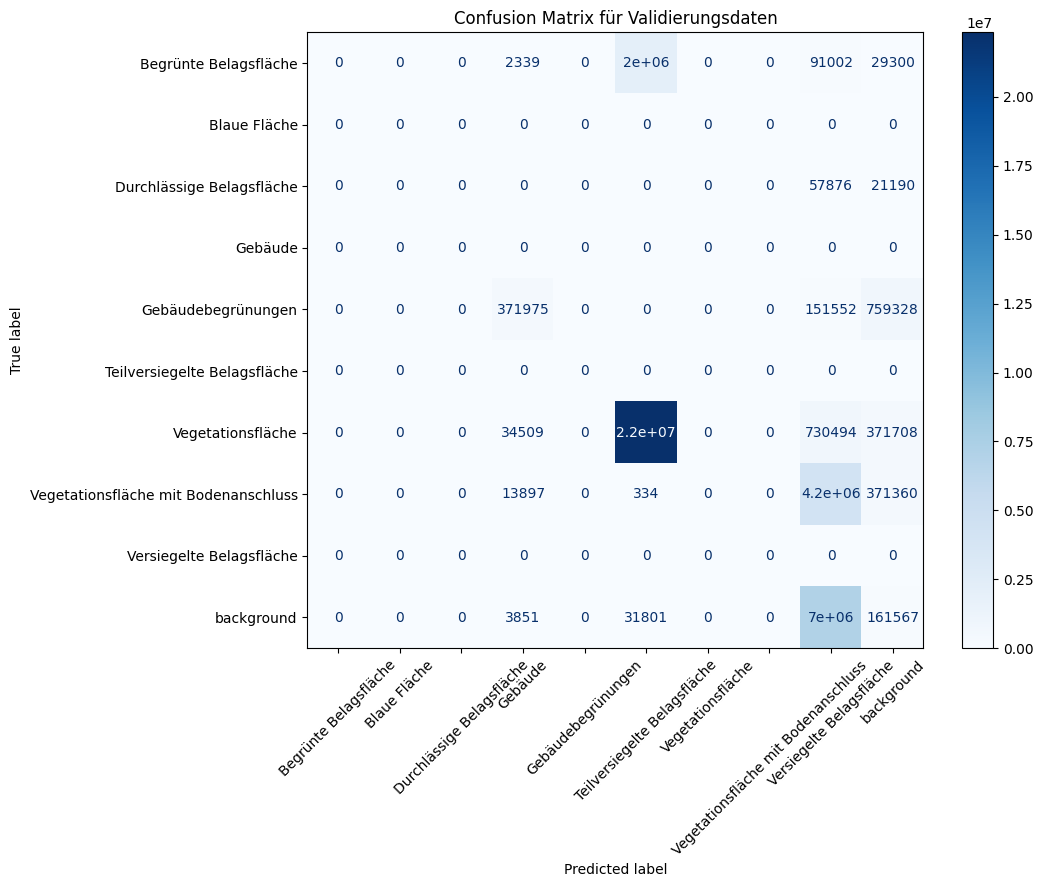

In [ ]:
import numpy as np
import pandas as pd
import torch
import rasterio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from segmentation_models_pytorch import Unet

# 1. Modell laden
model = Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=4,
    classes=11
)

# Checkpoint laden
checkpoint_path = "/content/drive/MyDrive/FLAIR/flair_model_2/checkpoints/last.ckpt"
state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))["state_dict"]
filtered_state_dict = {
    k.replace("model.seg_model.", ""): v
    for k, v in state_dict.items()
    if k.replace("model.seg_model.", "") in model.state_dict()
}
model.load_state_dict(filtered_state_dict, strict=False)
model.eval()

# 2. Ground-Truth- und Vorhersagedaten laden
val_csv_path = "/content/drive/MyDrive/Data/val_paths.csv"
val_data = pd.read_csv(val_csv_path, header=None, names=["image", "mask"])

ground_truth = []
predictions = []

for _, row in val_data.iterrows():
    # Ground Truth laden
    with rasterio.open(row["mask"]) as src:
        gt_mask = src.read(1)  # Nur die erste Bandmaske
        ground_truth.append(gt_mask.ravel())

    # Eingabebild laden und normalisieren
    with rasterio.open(row["image"]) as src:
        img = src.read()
        mean = np.array([105.08, 110.87, 101.82, 106.38])
        std = np.array([52.17, 45.38, 44, 39.69])
        img = (img - mean[:, None, None]) / std[:, None, None]

    # Vorhersagen
    with torch.no_grad():
        input_tensor = torch.from_numpy(img).float().unsqueeze(0)
        pred = model(input_tensor)
        pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()
        predictions.append(pred_mask.ravel())

# Arrays für Ground Truth und Predictions
ground_truth = np.concatenate(ground_truth)
predictions = np.concatenate(predictions)

# 3. Confusion Matrix berechnen
classes = [
    "Begrünte Belagsfläche", "Blaue Fläche", "Durchlässige Belagsfläche",
    "Gebäude", "Gebäudebegrünungen", "Teilversiegelte Belagsfläche",
    "Vegetationsfläche", "Vegetationsfläche mit Bodenanschluss",
    "Versiegelte Belagsfläche", "background"
]

cm = confusion_matrix(ground_truth, predictions, labels=list(range(len(classes))))

# 4. Confusion Matrix visualisieren
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix für Validierungsdaten")
plt.show()


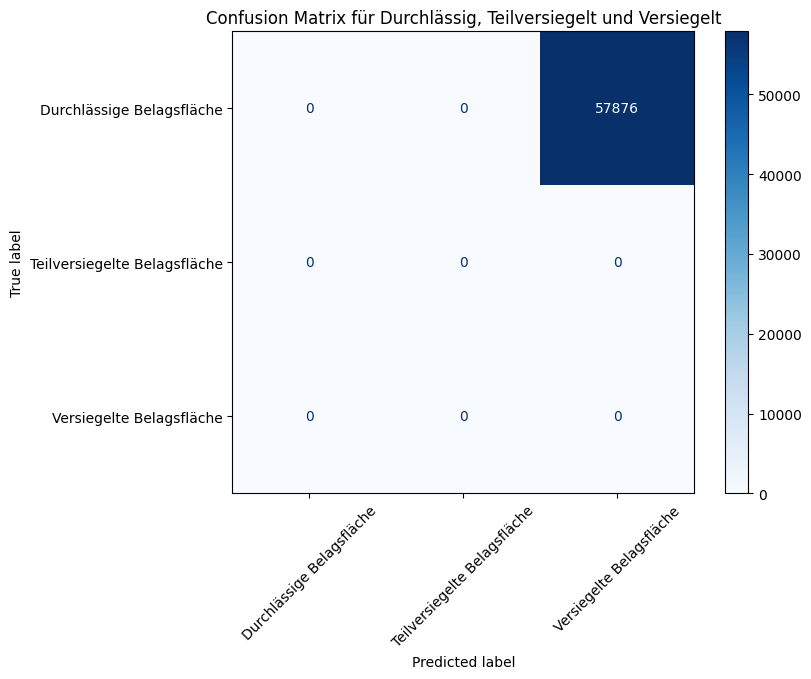

In [ ]:
# Filter für die drei Kategorien: Teilversiegelt, Durchlässig, Versiegelt
selected_classes = ["Durchlässige Belagsfläche", "Teilversiegelte Belagsfläche", "Versiegelte Belagsfläche"]
selected_indices = [classes.index(cls) for cls in selected_classes]

# Confusion Matrix für die ausgewählten Klassen extrahieren
filtered_cm = cm[np.ix_(selected_indices, selected_indices)]

# Visualisierung der gefilterten Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=filtered_cm, display_labels=selected_classes)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix für Durchlässig, Teilversiegelt und Versiegelt")
plt.show()

# Optional laufen lassen noch?

## YAML file (50 epochs)

In [ ]:
import yaml

# Inhalt des YAML-Files als Python-Dictionary
yaml_content = """
#### DATA PATHS
paths:
    out_folder : "/content/drive/MyDrive/FLAIR"  # Ausgabeverzeichnis für Ergebnisse
    out_model_name: "flair_model-2_50epochs"  # Name des Ausgabemodells

    # CSV-Dateien mit Bild-Masken-Paaren für Training und Validierung
    train_csv : "/content/drive/MyDrive/Data/augmented_train_paths.csv"
    val_csv   : "/content/drive/MyDrive/Data/val_paths.csv"

    # Optional: Testdaten, falls gewünscht
    test_csv : "/content/drive/MyDrive/Data/test_paths.csv"

    ckpt_model_path: ""  # Falls nötig, Pfad zur Checkpoint-Datei
    path_metadata_aerial: "../flair_aerial_metadata.json"  # Optional: Metadaten-JSON für FLAIR

#### USAGE
tasks:
    train: True  # Modelltraining aktivieren
    train_tasks:
        init_weights_only_from_ckpt: False  # Initialisiere nur Gewichte aus Checkpoint, falls gewünscht
        resume_training_from_ckpt: False  # Fortsetzen eines abgebrochenen Trainings
        early_stopping:
            monitor: val_loss  # oder eine andere Metrik wie val_miou, falls verfügbar
            patience: 3  # Anzahl der Epochen ohne Verbesserung, bevor abgebrochen wird
            mode: min  # Da 'val_loss' minimiert werden soll; für 'max' wäre dies bei Accuracy/Miou sinnvoll

    predict: True  # Vorhersagen mit dem Modell
    metrics: True  # Berechne Metriken
    delete_preds: True  # Lösche Vorhersagen nach Metrikberechnung

#### TRAINING CONFIGURATION
model_framework:
    model_provider: SegmentationModelsPytorch  # Framework-Provider für das Modell
    SegmentationModelsPytorch:
        encoder_decoder: "resnet34_unet"  # Encoder-Decoder-Konfiguration (resnet34 + U-Net)

use_augmentation: True  # Datenaugmentation aktivieren
transformations:
  - Resize: {height: 256, width: 256}
  - RandomHorizontalFlip: True
  - RandomVerticalFlip: True
  - RandomRotation: {degrees: 15}
  - ColorJitter: {brightness: 0.2, contrast: 0.2, saturation: 0.2, hue: 0.1}
use_metadata: False  # Falls Metadaten verwendet werden, auf True setzen (z.B. bei FLAIR)

channels: [1, 2, 3, 4]  # Eingabekanäle, z.B. RGB + NIR
norm_type: custom  # Normalisierungstyp (custom für Mean-Std)
norm_means: [105.08, 110.87, 101.82, 106.38]  # Mittelwerte für custom-Normalisierung
norm_stds: [52.17, 45.38, 44, 39.69]  # Standardabweichungen für custom-Normalisierung

seed: 2022  # Zufallswert für Reproduzierbarkeit
batch_size: 2  # Batchgröße
learning_rate: 0.03  # Lernrate
num_epochs: 50  # Anzahl der Trainingsepochen

#### DATA CONFIGURATION
use_weights: True  # Verwende Gewichtung der Klassen während des Trainings
classes: # Klassen-ID und Namen für semantische Segmentierung
    1:  [1, 'Begrünte Belagsfläche']
    2:  [1, 'Blaue Fläche']
    3:  [1, 'Durchlässige Belagsfläche']
    4:  [1, 'Gebäude']
    5:  [1, 'Gebäudebegrünungen']
    6:  [1, 'Keine Zuordnung']
    7:  [1, 'Teilversiegelte Belagsfläche']
    8:  [1, 'Vegetationsfläche']
    9:  [1, 'Vegetationsfläche mit Bodenanschluss']
    10: [1, 'Versiegelte Belagsflächen']
    0: [0, 'background']  # Hintergrundklasse

#### PREDICTION CONFIGURATION
georeferencing_output : True  # Georeferenzierte Ausgabe aktivieren

#### COMPUTATIONAL RESOURCES
accelerator: gpu  # 'gpu' für GPU-Training, 'cpu' für CPU
num_nodes: 1  # Anzahl der verwendeten Knoten
gpus_per_node: 1  # Anzahl der GPUs pro Knoten
strategy: 'auto'  # Strategie für verteiltes Training, falls nötig
num_workers: 10  # Anzahl der Arbeiter für Daten-Loading

#### CHECKPOINT OPTIONS
ckpt_save_also_last: True  # Speichere auch das letzte Epoch-Checkpoint
ckpt_verbose: False  # Ausführliche Informationen beim Speichern des Checkpoints
ckpt_weights_only: False  # Speichere nur die Gewichte, um Speicherplatz zu sparen
ckpt_monitor: val_loss  # Metrik für Checkpoint-Speicherung
ckpt_monitor_mode: min  # Speicher niedrigsten Wert für val_loss
ckpt_earlystopping_patience: 30  # Abbruch bei keiner Verbesserung nach 30 Epochen

#### PROGRESS PRINTING
cp_csv_and_conf_to_output: True  # Kopiere Pfade-CSV und Konfiguration zum Ausgabeverzeichnis
enable_progress_bar: True  # Zeige Fortschrittsbalken während des Trainings
progress_rate: 10  # Fortschrittsrate für die Anzeige
"""

# Speichere das YAML-File
with open("/content/drive/MyDrive/FLAIR/flair-2-config_50epochs.yaml", "w") as file:
    file.write(yaml_content)

In [ ]:
!flair --conf=/content/drive/MyDrive/FLAIR/flair-2-config_50epochs.yaml

/bin/bash: line 1: flair: command not found


### Analyse 50 epochs

In [ ]:
import numpy as np
import pandas as pd
import torch
import rasterio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from segmentation_models_pytorch import Unet

# 1. Modell laden
model = Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=4,
    classes=11
)

# Checkpoint laden
checkpoint_path = "/content/drive/MyDrive/FLAIR/flair-2-config_50epochs/checkpoints/last.ckpt"
state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))["state_dict"]
filtered_state_dict = {
    k.replace("model.seg_model.", ""): v
    for k, v in state_dict.items()
    if k.replace("model.seg_model.", "") in model.state_dict()
}
model.load_state_dict(filtered_state_dict, strict=False)
model.eval()

# 2. Ground-Truth- und Vorhersagedaten laden
val_csv_path = "/content/drive/MyDrive/Data/val_paths.csv"
val_data = pd.read_csv(val_csv_path, header=None, names=["image", "mask"])

ground_truth = []
predictions = []

for _, row in val_data.iterrows():
    # Ground Truth laden
    with rasterio.open(row["mask"]) as src:
        gt_mask = src.read(1)  # Nur die erste Bandmaske
        ground_truth.append(gt_mask.ravel())

    # Eingabebild laden und normalisieren
    with rasterio.open(row["image"]) as src:
        img = src.read()
        mean = np.array([105.08, 110.87, 101.82, 106.38])
        std = np.array([52.17, 45.38, 44, 39.69])
        img = (img - mean[:, None, None]) / std[:, None, None]

    # Vorhersagen
    with torch.no_grad():
        input_tensor = torch.from_numpy(img).float().unsqueeze(0)
        pred = model(input_tensor)
        pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()
        predictions.append(pred_mask.ravel())

# Arrays für Ground Truth und Predictions
ground_truth = np.concatenate(ground_truth)
predictions = np.concatenate(predictions)

# 3. Confusion Matrix berechnen
classes = [
    "Begrünte Belagsfläche", "Blaue Fläche", "Durchlässige Belagsfläche",
    "Gebäude", "Gebäudebegrünungen", "Teilversiegelte Belagsfläche",
    "Vegetationsfläche", "Vegetationsfläche mit Bodenanschluss",
    "Versiegelte Belagsfläche", "background"
]

cm = confusion_matrix(ground_truth, predictions, labels=list(range(len(classes))))

# 4. Confusion Matrix visualisieren
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix für Validierungsdaten")
plt.show()


In [ ]:
# Filter für die drei Kategorien: Teilversiegelt, Durchlässig, Versiegelt
selected_classes = ["Durchlässige Belagsfläche", "Teilversiegelte Belagsfläche", "Versiegelte Belagsfläche"]
selected_indices = [classes.index(cls) for cls in selected_classes]

# Confusion Matrix für die ausgewählten Klassen extrahieren
filtered_cm = cm[np.ix_(selected_indices, selected_indices)]

# Visualisierung der gefilterten Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=filtered_cm, display_labels=selected_classes)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix für Durchlässig, Teilversiegelt und Versiegelt")
plt.show()

# FLAIR model 3 mit angepassten Gewichtungen und 10 Klassen

aus segmentation Mask die Pixelwerte verwendet und dann die gewichte daraus berechnet

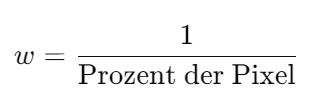

siehe Code aus Analysis Jupyter Notebook: Pixel pro Label ({'background': 48101906, 'Vegetationsfläche mit Bodenanschluss': 19263912, 'Gebäude': 10335640, 'Versiegelte Belagsfläche': 9690449, 'Teilversiegelte Belagsfläche': 5318270, 'Vegetationsfläche': 3001133, 'Durchlässige Belagsfläche': 1560545, 'Gebäudebegrünungen': 1538033, 'Begrünte Belagsfläche': 161784, 'Blaue Fläche': 79066})

normalisierung der daten

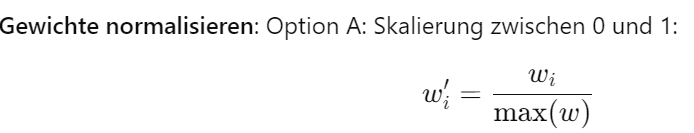

In [ ]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 22.1 MB/s eta 0:00:00


In [ ]:
from collections import Counter
import pandas as pd
import rasterio
import numpy as np

# Pfade zu den CSV-Dateien
data_csv_paths = [
    "/content/drive/MyDrive/Data/train_paths.csv",  # Trainingsdaten
    "/content/drive/MyDrive/Data/val_paths.csv",    # Validierungsdaten
    "/content/drive/MyDrive/Data/test_paths.csv"    # Testdaten
]

ground_truth = []

# Lade die Ground Truth Masken und extrahiere die Pixelwerte
for csv_path in data_csv_paths:
    data = pd.read_csv(csv_path, header=None, names=["image", "mask"])

    for _, row in data.iterrows():
        with rasterio.open(row["mask"]) as src:
            gt_mask = src.read(1)  # Nur die erste Bandmaske
            ground_truth.append(gt_mask.ravel())

# Arrays für Ground Truth
ground_truth = np.concatenate(ground_truth)

# Klassen-Namen aus den Daten abrufen, falls verfügbar
# Diese Zeile funktioniert, wenn die Masken oder Metadaten Namen zu Klassen-IDs enthalten
classes_from_data = {0: "background", 1: "Begrünte Belagsfläche", 2: "Blaue Fläche",
                     3: "Durchlässige Belagsfläche", 4: "Gebäude", 5: "Gebäudebegrünungen",
                     6: "Teilversiegelte Belagsfläche", 7: "Vegetationsfläche",
                     8: "Vegetationsfläche mit Bodenanschluss", 9: "Versiegelte Belagsfläche"}

# Zähle die Pixel in Ground Truth
ground_truth_counts = Counter(ground_truth)

# Übersicht erstellen
class_distribution_gt = []
for class_id, count in sorted(ground_truth_counts.items()):  # Sortiert nach Klassen-ID
    class_name = classes_from_data.get(class_id, f"Unbekannte Klasse {class_id}")  # Hole Namen aus der Zuordnung
    class_distribution_gt.append({
        "Klasse": class_name,
        "Ground Truth Pixel": count
    })

# Ergebnisse in DataFrame
df_ground_truth = pd.DataFrame(class_distribution_gt)

# Ergebnisse anzeigen
print("Pixelanzahl der Ground Truth:")
print(df_ground_truth)


Pixelanzahl der Ground Truth:
                                 Klasse  Ground Truth Pixel
0                            background             4778585
1                          Blaue Fläche               79066
2             Durchlässige Belagsfläche              895134
3                               Gebäude             5589135
4                    Gebäudebegrünungen               65464
5          Teilversiegelte Belagsfläche            36678914
6                     Vegetationsfläche             5167241
7  Vegetationsfläche mit Bodenanschluss             1290144
8              Versiegelte Belagsfläche            12945365
9                  Unbekannte Klasse 10             5255912


In [ ]:
# Gewichtungen berechnen und normalisieren
df_ground_truth["Gewichtung_normalisiert"] = df_ground_truth["Gewichtung"] / df_ground_truth["Gewichtung"].max()

# Ergebnisse anzeigen
print("Normalisierte Gewichtungen basierend auf den Ground Truth Pixeln:")
print(df_ground_truth[["Klasse", "Gewichtung_normalisiert"]])


Normalisierte Gewichtungen basierend auf den Ground Truth Pixeln:
                                 Klasse  Gewichtung_normalisiert
0                            background                 0.013699
1                          Blaue Fläche                 0.827967
2             Durchlässige Belagsfläche                 0.073133
3                               Gebäude                 0.011713
4                    Gebäudebegrünungen                 1.000000
5          Teilversiegelte Belagsfläche                 0.001785
6                     Vegetationsfläche                 0.012669
7  Vegetationsfläche mit Bodenanschluss                 0.050742
8              Versiegelte Belagsfläche                 0.005057
9                  Unbekannte Klasse 10                 0.012455


## YAML File konfigurieren (5 epochs)

In [ ]:
import yaml

# Inhalt des YAML-Files als Python-Dictionary
yaml_content = """
#### DATA PATHS
paths:
    out_folder : "/content/drive/MyDrive/FLAIR"  # Ausgabeverzeichnis für Ergebnisse
    out_model_name: "flair_model_3"  # Name des Ausgabemodells

    # CSV-Dateien mit Bild-Masken-Paaren für Training und Validierung
    train_csv : "/content/drive/MyDrive/Data/augmented_train_paths.csv"
    val_csv   : "/content/drive/MyDrive/Data/val_paths.csv"

    # Optional: Testdaten, falls gewünscht
    test_csv : "/content/drive/MyDrive/Data/test_paths.csv"

    ckpt_model_path: ""  # Falls nötig, Pfad zur Checkpoint-Datei
    path_metadata_aerial: "../flair_aerial_metadata.json"  # Optional: Metadaten-JSON für FLAIR

#### USAGE
tasks:
    train: True  # Modelltraining aktivieren
    train_tasks:
        init_weights_only_from_ckpt: False  # Initialisiere nur Gewichte aus Checkpoint, falls gewünscht
        resume_training_from_ckpt: False  # Fortsetzen eines abgebrochenen Trainings
        early_stopping:
            monitor: val_loss  # oder eine andere Metrik wie val_miou, falls verfügbar
            patience: 3  # Anzahl der Epochen ohne Verbesserung, bevor abgebrochen wird
            mode: min  # Da 'val_loss' minimiert werden soll; für 'max' wäre dies bei Accuracy/Miou sinnvoll

    predict: True  # Vorhersagen mit dem Modell
    metrics: True  # Berechne Metriken
    delete_preds: True  # Lösche Vorhersagen nach Metrikberechnung

#### TRAINING CONFIGURATION
model_framework:
    model_provider: SegmentationModelsPytorch  # Framework-Provider für das Modell
    SegmentationModelsPytorch:
        encoder_decoder: "resnet34_unet"  # Encoder-Decoder-Konfiguration (resnet34 + U-Net)

use_augmentation: True  # Datenaugmentation aktivieren
transformations:
  - Resize: {height: 256, width: 256}
  - RandomHorizontalFlip: True
  - RandomVerticalFlip: True
  - RandomRotation: {degrees: 15}
  - ColorJitter: {brightness: 0.2, contrast: 0.2, saturation: 0.2, hue: 0.1}
use_metadata: False  # Falls Metadaten verwendet werden, auf True setzen (z.B. bei FLAIR)

channels: [1, 2, 3, 4]  # Eingabekanäle, z.B. RGB + NIR
norm_type: custom  # Normalisierungstyp (custom für Mean-Std)
norm_means: [105.08, 110.87, 101.82, 106.38]  # Mittelwerte für custom-Normalisierung
norm_stds: [52.17, 45.38, 44, 39.69]  # Standardabweichungen für custom-Normalisierung

seed: 2022  # Zufallswert für Reproduzierbarkeit
batch_size: 2  # Batchgröße
learning_rate: 0.03  # Lernrate
num_epochs: 5  # Anzahl der Trainingsepochen

#### DATA CONFIGURATION
use_weights: True  # Verwende Gewichtung der Klassen während des Trainings
classes:
    1:  [0.013699, 'Begrünte Belagsfläche']
    2:  [0.827967, 'Blaue Fläche']
    3:  [0.073133, 'Durchlässige Belagsfläche']
    4:  [0.011713, 'Gebäude']
    5:  [1.000000, 'Gebäudebegrünungen']
    6:  [0.001785, 'Teilversiegelte Belagsfläche']
    7:  [0.012669, 'Vegetationsfläche']
    8:  [0.050742, 'Vegetationsfläche mit Bodenanschluss']
    9:  [0.005057, 'Versiegelte Belagsfläche']
    0:  [0.012455, 'background']


#### PREDICTION CONFIGURATION
georeferencing_output : True  # Georeferenzierte Ausgabe aktivieren

#### COMPUTATIONAL RESOURCES
accelerator: gpu  # 'gpu' für GPU-Training, 'cpu' für CPU
num_nodes: 1  # Anzahl der verwendeten Knoten
gpus_per_node: 1  # Anzahl der GPUs pro Knoten
strategy: 'auto'  # Strategie für verteiltes Training, falls nötig
num_workers: 10  # Anzahl der Arbeiter für Daten-Loading

#### CHECKPOINT OPTIONS
ckpt_save_also_last: True  # Speichere auch das letzte Epoch-Checkpoint
ckpt_verbose: False  # Ausführliche Informationen beim Speichern des Checkpoints
ckpt_weights_only: False  # Speichere nur die Gewichte, um Speicherplatz zu sparen
ckpt_monitor: val_loss  # Metrik für Checkpoint-Speicherung
ckpt_monitor_mode: min  # Speicher niedrigsten Wert für val_loss
ckpt_earlystopping_patience: 30  # Abbruch bei keiner Verbesserung nach 30 Epochen

#### PROGRESS PRINTING
cp_csv_and_conf_to_output: True  # Kopiere Pfade-CSV und Konfiguration zum Ausgabeverzeichnis
enable_progress_bar: True  # Zeige Fortschrittsbalken während des Trainings
progress_rate: 10  # Fortschrittsrate für die Anzeige
"""

# Speichere das YAML-File
with open("/content/drive/MyDrive/FLAIR/flair-3-config.yaml", "w") as file:
    file.write(yaml_content)

In [ ]:
!flair --conf=/content/drive/MyDrive/FLAIR/flair-3-config.yaml

2024-12-11 21:35:45.723152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 21:35:45.742494: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 21:35:45.748388: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 21:35:45.763205: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-11 21:35:47.282612: W tensorflow/comp

### Analyse

<ipython-input-4-a1277605d504>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))["state_dict"]


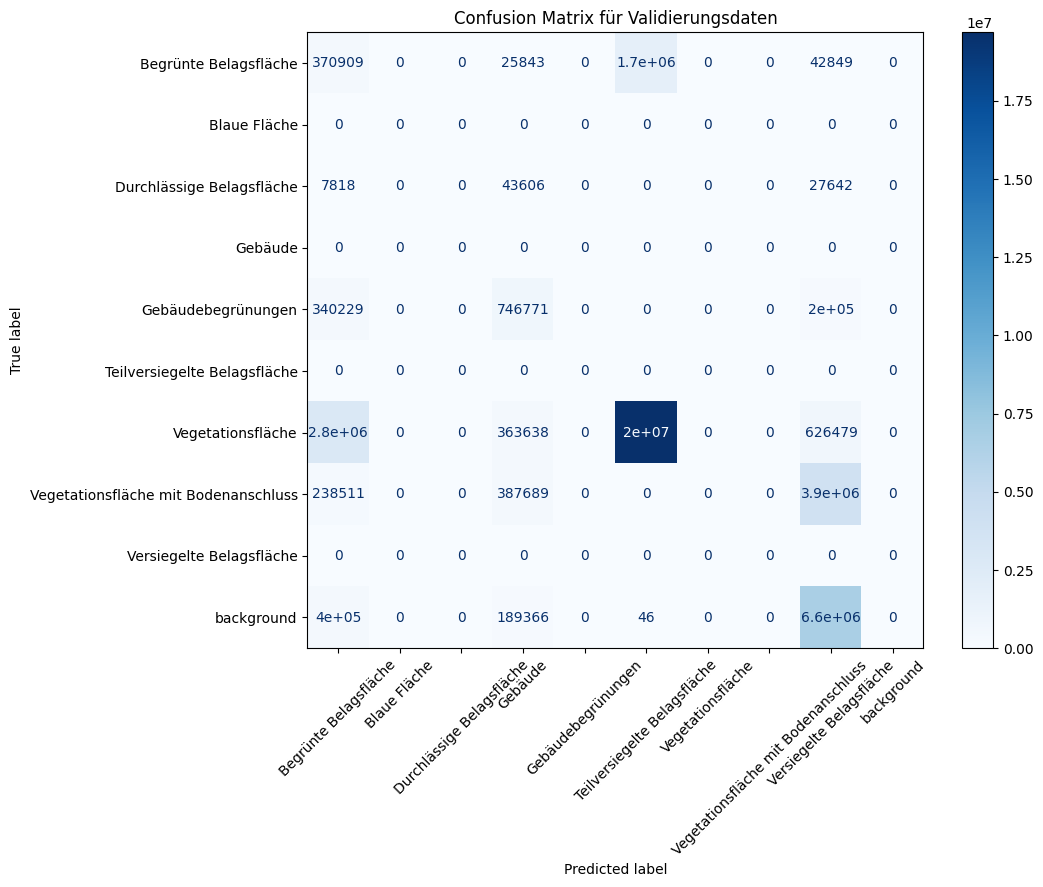

In [ ]:
import numpy as np
import pandas as pd
import torch
import rasterio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from segmentation_models_pytorch import Unet

# 1. Modell laden
model = Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=4,
    classes=10
)

# Checkpoint laden
checkpoint_path = "/content/drive/MyDrive/FLAIR/flair_model_3/checkpoints/last.ckpt"
state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))["state_dict"]
filtered_state_dict = {
    k.replace("model.seg_model.", ""): v
    for k, v in state_dict.items()
    if k.replace("model.seg_model.", "") in model.state_dict()
}
model.load_state_dict(filtered_state_dict, strict=False)
model.eval()

# 2. Ground-Truth- und Vorhersagedaten laden
val_csv_path = "/content/drive/MyDrive/Data/val_paths.csv"
val_data = pd.read_csv(val_csv_path, header=None, names=["image", "mask"])

ground_truth = []
predictions = []

for _, row in val_data.iterrows():
    # Ground Truth laden
    with rasterio.open(row["mask"]) as src:
        gt_mask = src.read(1)  # Nur die erste Bandmaske
        ground_truth.append(gt_mask.ravel())

    # Eingabebild laden und normalisieren
    with rasterio.open(row["image"]) as src:
        img = src.read()
        mean = np.array([105.08, 110.87, 101.82, 106.38])
        std = np.array([52.17, 45.38, 44, 39.69])
        img = (img - mean[:, None, None]) / std[:, None, None]

    # Vorhersagen
    with torch.no_grad():
        input_tensor = torch.from_numpy(img).float().unsqueeze(0)
        pred = model(input_tensor)
        pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()
        predictions.append(pred_mask.ravel())

# Arrays für Ground Truth und Predictions
ground_truth = np.concatenate(ground_truth)
predictions = np.concatenate(predictions)

# 3. Confusion Matrix berechnen
classes = [
    "Begrünte Belagsfläche", "Blaue Fläche", "Durchlässige Belagsfläche",
    "Gebäude", "Gebäudebegrünungen", "Teilversiegelte Belagsfläche",
    "Vegetationsfläche", "Vegetationsfläche mit Bodenanschluss",
    "Versiegelte Belagsfläche", "background"
]

cm = confusion_matrix(ground_truth, predictions, labels=list(range(len(classes))))

# 4. Confusion Matrix visualisieren
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix für Validierungsdaten")
plt.show()


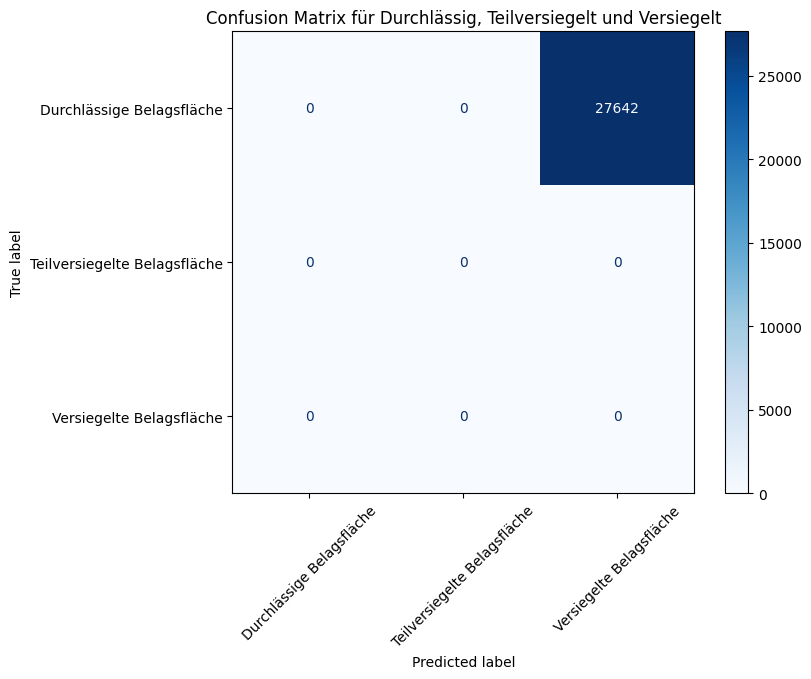

In [ ]:
# Filter für die drei Kategorien: Teilversiegelt, Durchlässig, Versiegelt
selected_classes = ["Durchlässige Belagsfläche", "Teilversiegelte Belagsfläche", "Versiegelte Belagsfläche"]
selected_indices = [classes.index(cls) for cls in selected_classes]

# Confusion Matrix für die ausgewählten Klassen extrahieren
filtered_cm = cm[np.ix_(selected_indices, selected_indices)]

# Visualisierung der gefilterten Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=filtered_cm, display_labels=selected_classes)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix für Durchlässig, Teilversiegelt und Versiegelt")
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


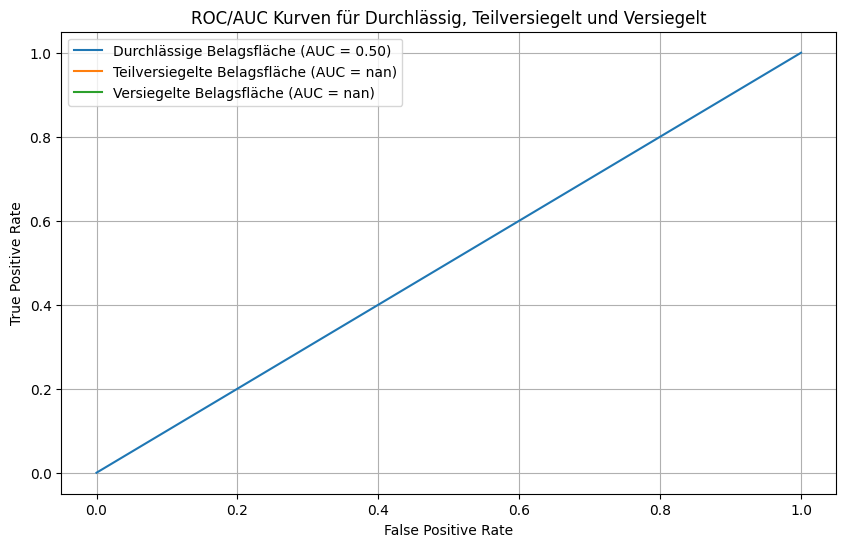

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC/AUC Kurven für die drei ausgewählten Klassen
plt.figure(figsize=(10, 6))
for idx, class_name in zip(selected_indices, selected_classes):
    # Binäre Umwandlung der Ground Truth und Predictions für die aktuelle Klasse
    gt_binary = (ground_truth == idx).astype(int)
    pred_binary = (predictions == idx).astype(int)

    # Berechnung der ROC-Kurve und AUC
    fpr, tpr, _ = roc_curve(gt_binary, pred_binary)
    roc_auc = auc(fpr, tpr)

    # Plot der ROC-Kurve
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

# Plot-Details
plt.title("ROC/AUC Kurven für Durchlässig, Teilversiegelt und Versiegelt")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


## Yaml File 3 mit 50 epochs

In [ ]:
import yaml

# Inhalt des YAML-Files als Python-Dictionary
yaml_content = """
#### DATA PATHS
paths:
    out_folder : "/content/drive/MyDrive/FLAIR"  # Ausgabeverzeichnis für Ergebnisse
    out_model_name: "flair_model_3_50epochs"  # Name des Ausgabemodells

    # CSV-Dateien mit Bild-Masken-Paaren für Training und Validierung
    train_csv : "/content/drive/MyDrive/Data/augmented_train_paths.csv"
    val_csv   : "/content/drive/MyDrive/Data/val_paths.csv"

    # Optional: Testdaten, falls gewünscht
    test_csv : "/content/drive/MyDrive/Data/test_paths.csv"

    ckpt_model_path: ""  # Falls nötig, Pfad zur Checkpoint-Datei
    path_metadata_aerial: "../flair_aerial_metadata.json"  # Optional: Metadaten-JSON für FLAIR

#### USAGE
tasks:
    train: True  # Modelltraining aktivieren
    train_tasks:
        init_weights_only_from_ckpt: False  # Initialisiere nur Gewichte aus Checkpoint, falls gewünscht
        resume_training_from_ckpt: False  # Fortsetzen eines abgebrochenen Trainings
        early_stopping:
            monitor: val_loss  # oder eine andere Metrik wie val_miou, falls verfügbar
            patience: 3  # Anzahl der Epochen ohne Verbesserung, bevor abgebrochen wird
            mode: min  # Da 'val_loss' minimiert werden soll; für 'max' wäre dies bei Accuracy/Miou sinnvoll

    predict: True  # Vorhersagen mit dem Modell
    metrics: True  # Berechne Metriken
    delete_preds: True  # Lösche Vorhersagen nach Metrikberechnung

#### TRAINING CONFIGURATION
model_framework:
    model_provider: SegmentationModelsPytorch  # Framework-Provider für das Modell
    SegmentationModelsPytorch:
        encoder_decoder: "resnet34_unet"  # Encoder-Decoder-Konfiguration (resnet34 + U-Net)

use_augmentation: True  # Datenaugmentation aktivieren
transformations:
  - Resize: {height: 256, width: 256}
  - RandomHorizontalFlip: True
  - RandomVerticalFlip: True
  - RandomRotation: {degrees: 15}
  - ColorJitter: {brightness: 0.2, contrast: 0.2, saturation: 0.2, hue: 0.1}
use_metadata: False  # Falls Metadaten verwendet werden, auf True setzen (z.B. bei FLAIR)

channels: [1, 2, 3, 4]  # Eingabekanäle, z.B. RGB + NIR
norm_type: custom  # Normalisierungstyp (custom für Mean-Std)
norm_means: [105.08, 110.87, 101.82, 106.38]  # Mittelwerte für custom-Normalisierung
norm_stds: [52.17, 45.38, 44, 39.69]  # Standardabweichungen für custom-Normalisierung

seed: 2022  # Zufallswert für Reproduzierbarkeit
batch_size: 2  # Batchgröße
learning_rate: 0.03  # Lernrate
num_epochs: 50  # Anzahl der Trainingsepochen

#### DATA CONFIGURATION
use_weights: True  # Verwende Gewichtung der Klassen während des Trainings
classes:
    1:  [0.013699, 'Begrünte Belagsfläche']
    2:  [0.827967, 'Blaue Fläche']
    3:  [0.073133, 'Durchlässige Belagsfläche']
    4:  [0.011713, 'Gebäude']
    5:  [1.000000, 'Gebäudebegrünungen']
    6:  [0.001785, 'Teilversiegelte Belagsfläche']
    7:  [0.012669, 'Vegetationsfläche']
    8:  [0.050742, 'Vegetationsfläche mit Bodenanschluss']
    9:  [0.005057, 'Versiegelte Belagsfläche']
    0:  [0.012455, 'background']


#### PREDICTION CONFIGURATION
georeferencing_output : True  # Georeferenzierte Ausgabe aktivieren

#### COMPUTATIONAL RESOURCES
accelerator: gpu  # 'gpu' für GPU-Training, 'cpu' für CPU
num_nodes: 1  # Anzahl der verwendeten Knoten
gpus_per_node: 1  # Anzahl der GPUs pro Knoten
strategy: 'auto'  # Strategie für verteiltes Training, falls nötig
num_workers: 10  # Anzahl der Arbeiter für Daten-Loading

#### CHECKPOINT OPTIONS
ckpt_save_also_last: True  # Speichere auch das letzte Epoch-Checkpoint
ckpt_verbose: False  # Ausführliche Informationen beim Speichern des Checkpoints
ckpt_weights_only: False  # Speichere nur die Gewichte, um Speicherplatz zu sparen
ckpt_monitor: val_loss  # Metrik für Checkpoint-Speicherung
ckpt_monitor_mode: min  # Speicher niedrigsten Wert für val_loss
ckpt_earlystopping_patience: 30  # Abbruch bei keiner Verbesserung nach 30 Epochen

#### PROGRESS PRINTING
cp_csv_and_conf_to_output: True  # Kopiere Pfade-CSV und Konfiguration zum Ausgabeverzeichnis
enable_progress_bar: True  # Zeige Fortschrittsbalken während des Trainings
progress_rate: 10  # Fortschrittsrate für die Anzeige
"""

# Speichere das YAML-File
with open("/content/drive/MyDrive/FLAIR/flair-3-config_50epochs.yaml", "w") as file:
    file.write(yaml_content)

In [ ]:
!flair --conf=/content/drive/MyDrive/FLAIR/flair-3-config_50epochs.yaml

2024-12-16 10:06:06.000278: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 10:06:06.015901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-16 10:06:06.035976: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-16 10:06:06.042506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 10:06:06.057968: I tensorflow/core/platform/cpu_feature_guar

### Analyse (50 epochs)

<ipython-input-9-fbeac3a31f5a>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))["state_dict"]


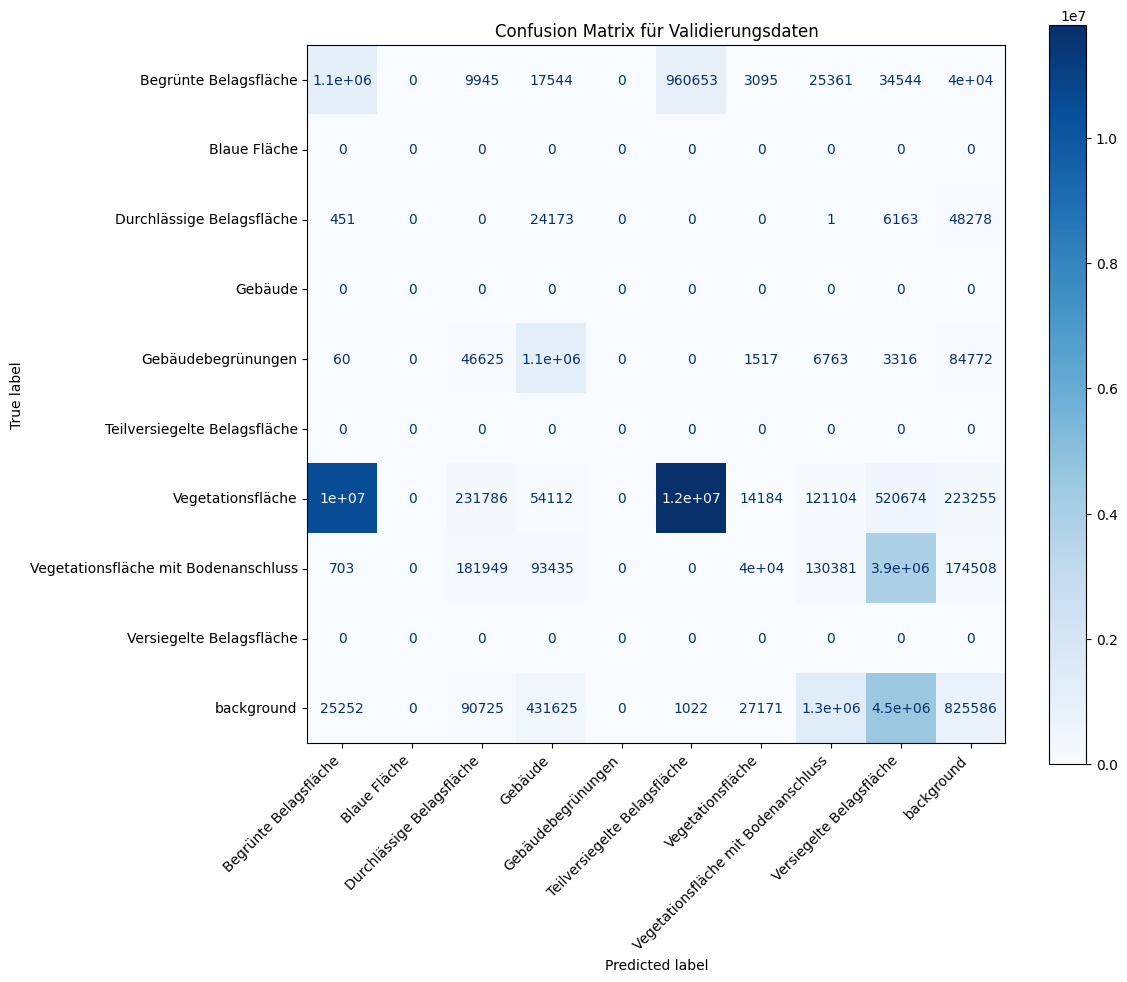

In [ ]:
import numpy as np
import pandas as pd
import torch
import rasterio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from segmentation_models_pytorch import Unet

# 1. Modell laden
model = Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=4,
    classes=10
)

# Checkpoint laden
checkpoint_path = "/content/drive/MyDrive/FLAIR/flair_model_3_50epochs/checkpoints/last.ckpt"
state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))["state_dict"]
filtered_state_dict = {
    k.replace("model.seg_model.", ""): v
    for k, v in state_dict.items()
    if k.replace("model.seg_model.", "") in model.state_dict()
}
model.load_state_dict(filtered_state_dict, strict=False)
model.eval()

# 2. Ground-Truth- und Vorhersagedaten laden
val_csv_path = "/content/drive/MyDrive/Data/val_paths.csv"
val_data = pd.read_csv(val_csv_path, header=None, names=["image", "mask"])

ground_truth = []
predictions = []

for _, row in val_data.iterrows():
    # Ground Truth laden
    with rasterio.open(row["mask"]) as src:
        gt_mask = src.read(1)  # Nur die erste Bandmaske
        ground_truth.append(gt_mask.ravel())

    # Eingabebild laden und normalisieren
    with rasterio.open(row["image"]) as src:
        img = src.read()
        mean = np.array([105.08, 110.87, 101.82, 106.38])
        std = np.array([52.17, 45.38, 44, 39.69])
        img = (img - mean[:, None, None]) / std[:, None, None]

    # Vorhersagen
    with torch.no_grad():
        input_tensor = torch.from_numpy(img).float().unsqueeze(0)
        pred = model(input_tensor)
        pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()
        predictions.append(pred_mask.ravel())

# Arrays für Ground Truth und Predictions
ground_truth = np.concatenate(ground_truth)
predictions = np.concatenate(predictions)

# 3. Confusion Matrix berechnen
classes = [
    "Begrünte Belagsfläche", "Blaue Fläche", "Durchlässige Belagsfläche",
    "Gebäude", "Gebäudebegrünungen", "Teilversiegelte Belagsfläche",
    "Vegetationsfläche", "Vegetationsfläche mit Bodenanschluss",
    "Versiegelte Belagsfläche", "background"
]

cm = confusion_matrix(ground_truth, predictions, labels=list(range(len(classes))))

# 4. Confusion Matrix visualisieren
fig, ax = plt.subplots(figsize=(12, 10))  # Größeres Plot-Fenster
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)

# Achsenticks korrekt ausrichten
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(classes)), labels=classes, rotation=0, va="center")

# Titel hinzufügen
plt.title("Confusion Matrix für Validierungsdaten")
plt.tight_layout()  # Sorgt für saubere Anzeige
plt.show()


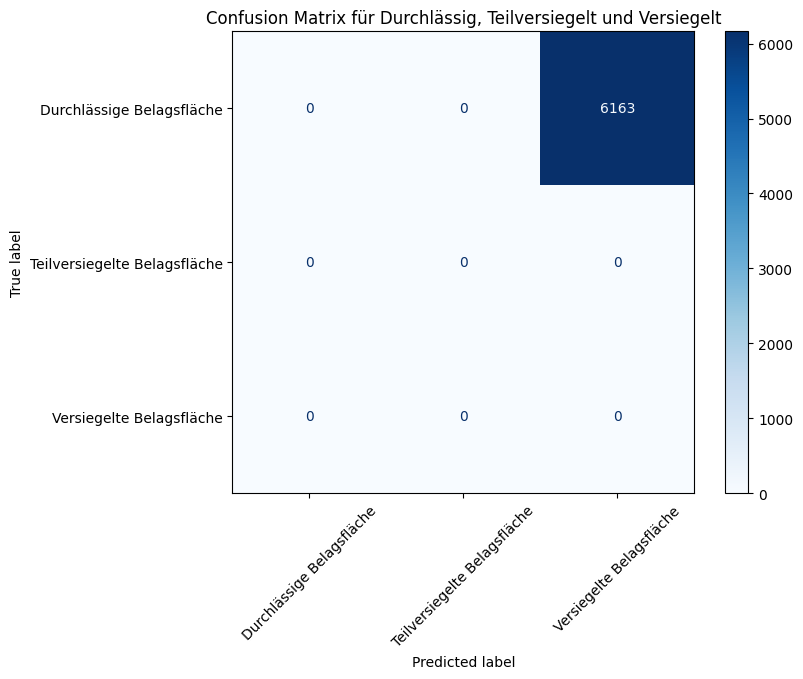

In [ ]:
# Filter für die drei Kategorien: Teilversiegelt, Durchlässig, Versiegelt
selected_classes = ["Durchlässige Belagsfläche", "Teilversiegelte Belagsfläche", "Versiegelte Belagsfläche"]
selected_indices = [classes.index(cls) for cls in selected_classes]

# Confusion Matrix für die ausgewählten Klassen extrahieren
filtered_cm = cm[np.ix_(selected_indices, selected_indices)]

# Visualisierung der gefilterten Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=filtered_cm, display_labels=selected_classes)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix für Durchlässig, Teilversiegelt und Versiegelt")
plt.show()


# FLAIR Model 4 mit grösserer Batch Size



## Yaml File mit Batch Size

In [ ]:
import yaml

# Inhalt des YAML-Files als Python-Dictionary
yaml_content = """
#### DATA PATHS
paths:
    out_folder : "/content/drive/MyDrive/FLAIR"  # Ausgabeverzeichnis für Ergebnisse
    out_model_name: "flair_model_4"  # Name des Ausgabemodells

    # CSV-Dateien mit Bild-Masken-Paaren für Training und Validierung
    train_csv : "/content/drive/MyDrive/Data/augmented_train_paths.csv"
    val_csv   : "/content/drive/MyDrive/Data/val_paths.csv"

    # Optional: Testdaten, falls gewünscht
    test_csv : "/content/drive/MyDrive/Data/test_paths.csv"

    ckpt_model_path: ""  # Falls nötig, Pfad zur Checkpoint-Datei
    path_metadata_aerial: "../flair_aerial_metadata.json"  # Optional: Metadaten-JSON für FLAIR

#### USAGE
tasks:
    train: True  # Modelltraining aktivieren
    train_tasks:
        init_weights_only_from_ckpt: False  # Initialisiere nur Gewichte aus Checkpoint, falls gewünscht
        resume_training_from_ckpt: False  # Fortsetzen eines abgebrochenen Trainings
        early_stopping:
            monitor: val_loss  # oder eine andere Metrik wie val_miou, falls verfügbar
            patience: 3  # Anzahl der Epochen ohne Verbesserung, bevor abgebrochen wird
            mode: min  # Da 'val_loss' minimiert werden soll; für 'max' wäre dies bei Accuracy/Miou sinnvoll

    predict: True  # Vorhersagen mit dem Modell
    metrics: True  # Berechne Metriken
    delete_preds: True  # Lösche Vorhersagen nach Metrikberechnung

#### TRAINING CONFIGURATION
model_framework:
    model_provider: SegmentationModelsPytorch  # Framework-Provider für das Modell
    SegmentationModelsPytorch:
        encoder_decoder: "resnet34_unet"  # Encoder-Decoder-Konfiguration (resnet34 + U-Net)

use_augmentation: True  # Datenaugmentation aktivieren
transformations:
  - Resize: {height: 256, width: 256}
  - RandomHorizontalFlip: True
  - RandomVerticalFlip: True
  - RandomRotation: {degrees: 15}
  - ColorJitter: {brightness: 0.2, contrast: 0.2, saturation: 0.2, hue: 0.1}
use_metadata: False  # Falls Metadaten verwendet werden, auf True setzen (z.B. bei FLAIR)

channels: [1, 2, 3, 4]  # Eingabekanäle, z.B. RGB + NIR
norm_type: custom  # Normalisierungstyp (custom für Mean-Std)
norm_means: [105.08, 110.87, 101.82, 106.38]  # Mittelwerte für custom-Normalisierung
norm_stds: [52.17, 45.38, 44, 39.69]  # Standardabweichungen für custom-Normalisierung

seed: 2022  # Zufallswert für Reproduzierbarkeit
batch_size: 32  # Batchgröße
learning_rate: 0.03  # Lernrate
num_epochs: 10  # Anzahl der Trainingsepochen

#### DATA CONFIGURATION
use_weights: True  # Verwende Gewichtung der Klassen während des Trainings
classes:
    1:  [0.013699, 'Begrünte Belagsfläche']
    2:  [0.827967, 'Blaue Fläche']
    3:  [0.073133, 'Durchlässige Belagsfläche']
    4:  [0.011713, 'Gebäude']
    5:  [1.000000, 'Gebäudebegrünungen']
    6:  [0.001785, 'Teilversiegelte Belagsfläche']
    7:  [0.012669, 'Vegetationsfläche']
    8:  [0.050742, 'Vegetationsfläche mit Bodenanschluss']
    9:  [0.005057, 'Versiegelte Belagsfläche']
    0:  [0.012455, 'background']


#### PREDICTION CONFIGURATION
georeferencing_output : True  # Georeferenzierte Ausgabe aktivieren

#### COMPUTATIONAL RESOURCES
accelerator: gpu  # 'gpu' für GPU-Training, 'cpu' für CPU
num_nodes: 1  # Anzahl der verwendeten Knoten
gpus_per_node: 1  # Anzahl der GPUs pro Knoten
strategy: 'auto'  # Strategie für verteiltes Training, falls nötig
num_workers: 10  # Anzahl der Arbeiter für Daten-Loading

#### CHECKPOINT OPTIONS
ckpt_save_also_last: True  # Speichere auch das letzte Epoch-Checkpoint
ckpt_verbose: False  # Ausführliche Informationen beim Speichern des Checkpoints
ckpt_weights_only: False  # Speichere nur die Gewichte, um Speicherplatz zu sparen
ckpt_monitor: val_loss  # Metrik für Checkpoint-Speicherung
ckpt_monitor_mode: min  # Speicher niedrigsten Wert für val_loss
ckpt_earlystopping_patience: 30  # Abbruch bei keiner Verbesserung nach 30 Epochen

#### PROGRESS PRINTING
cp_csv_and_conf_to_output: True  # Kopiere Pfade-CSV und Konfiguration zum Ausgabeverzeichnis
enable_progress_bar: True  # Zeige Fortschrittsbalken während des Trainings
progress_rate: 10  # Fortschrittsrate für die Anzeige
"""

# Speichere das YAML-File
with open("/content/drive/MyDrive/FLAIR/flair-4-config.yaml", "w") as file:
    file.write(yaml_content)

In [ ]:
!flair --conf=/content/drive/MyDrive/FLAIR/flair-4-config.yaml

2024-12-16 13:41:06.272857: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 13:41:06.290472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-16 13:41:06.312749: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-16 13:41:06.319372: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 13:41:06.335120: I tensorflow/core/platform/cpu_feature_guar

<ipython-input-3-3ad2f839e8de>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))["state_dict"]


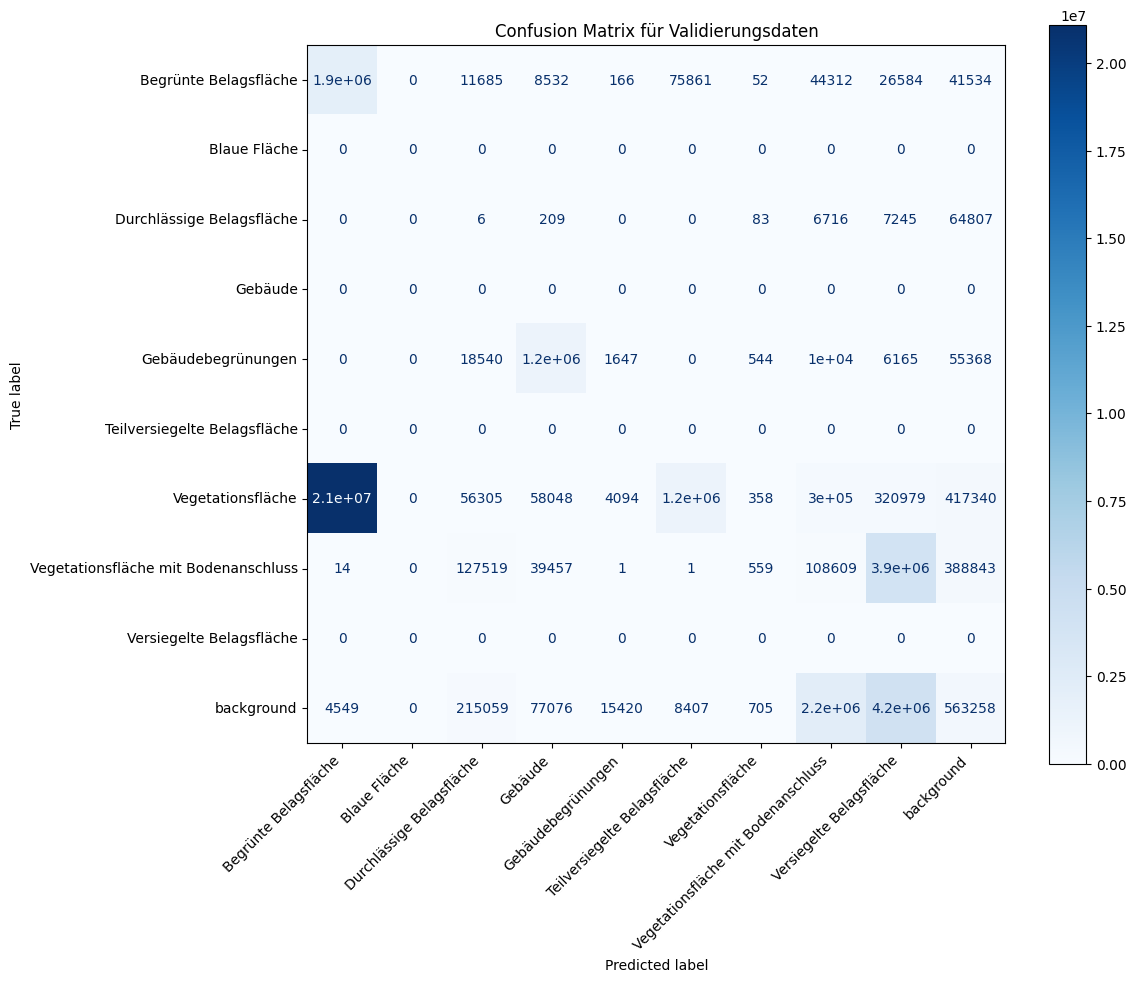

In [ ]:
import numpy as np
import pandas as pd
import torch
import rasterio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from segmentation_models_pytorch import Unet

# 1. Modell laden
model = Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=4,
    classes=10
)

# Checkpoint laden
checkpoint_path = "/content/drive/MyDrive/FLAIR/flair_model_4/checkpoints/last.ckpt"
state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))["state_dict"]
filtered_state_dict = {
    k.replace("model.seg_model.", ""): v
    for k, v in state_dict.items()
    if k.replace("model.seg_model.", "") in model.state_dict()
}
model.load_state_dict(filtered_state_dict, strict=False)
model.eval()

# 2. Ground-Truth- und Vorhersagedaten laden
val_csv_path = "/content/drive/MyDrive/Data/val_paths.csv"
val_data = pd.read_csv(val_csv_path, header=None, names=["image", "mask"])

ground_truth = []
predictions = []

for _, row in val_data.iterrows():
    # Ground Truth laden
    with rasterio.open(row["mask"]) as src:
        gt_mask = src.read(1)  # Nur die erste Bandmaske
        ground_truth.append(gt_mask.ravel())

    # Eingabebild laden und normalisieren
    with rasterio.open(row["image"]) as src:
        img = src.read()
        mean = np.array([105.08, 110.87, 101.82, 106.38])
        std = np.array([52.17, 45.38, 44, 39.69])
        img = (img - mean[:, None, None]) / std[:, None, None]

    # Vorhersagen
    with torch.no_grad():
        input_tensor = torch.from_numpy(img).float().unsqueeze(0)
        pred = model(input_tensor)
        pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()
        predictions.append(pred_mask.ravel())

# Arrays für Ground Truth und Predictions
ground_truth = np.concatenate(ground_truth)
predictions = np.concatenate(predictions)

# 3. Confusion Matrix berechnen
classes = [
    "Begrünte Belagsfläche", "Blaue Fläche", "Durchlässige Belagsfläche",
    "Gebäude", "Gebäudebegrünungen", "Teilversiegelte Belagsfläche",
    "Vegetationsfläche", "Vegetationsfläche mit Bodenanschluss",
    "Versiegelte Belagsfläche", "background"
]

cm = confusion_matrix(ground_truth, predictions, labels=list(range(len(classes))))

# 4. Confusion Matrix visualisieren
fig, ax = plt.subplots(figsize=(12, 10))  # Größeres Plot-Fenster
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)

# Achsenticks korrekt ausrichten
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(classes)), labels=classes, rotation=0, va="center")

# Titel hinzufügen
plt.title("Confusion Matrix für Validierungsdaten")
plt.tight_layout()  # Sorgt für saubere Anzeige
plt.show()


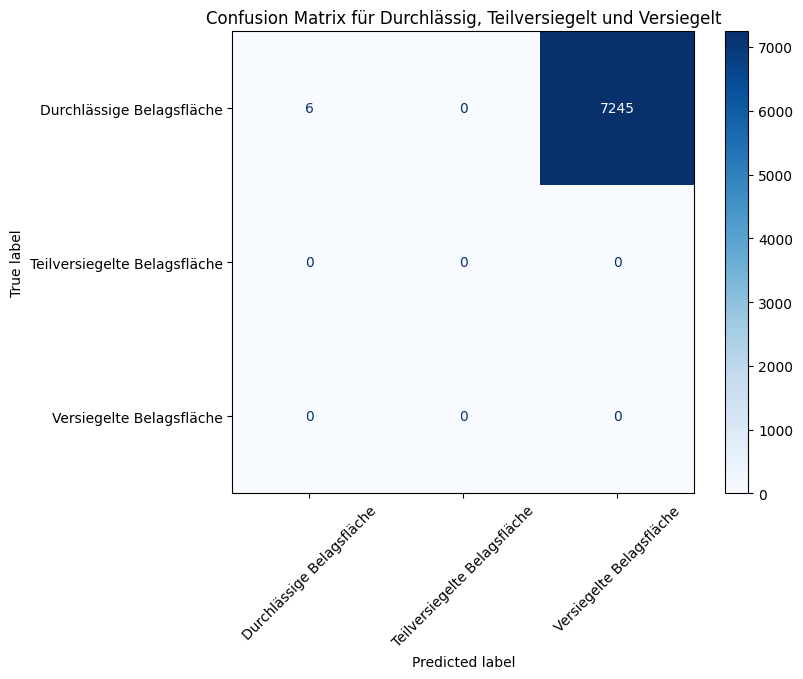

In [ ]:
# Filter für die drei Kategorien: Teilversiegelt, Durchlässig, Versiegelt
selected_classes = ["Durchlässige Belagsfläche", "Teilversiegelte Belagsfläche", "Versiegelte Belagsfläche"]
selected_indices = [classes.index(cls) for cls in selected_classes]

# Confusion Matrix für die ausgewählten Klassen extrahieren
filtered_cm = cm[np.ix_(selected_indices, selected_indices)]

# Visualisierung der gefilterten Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=filtered_cm, display_labels=selected_classes)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix für Durchlässig, Teilversiegelt und Versiegelt")
plt.show()
